In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import joblib
import os
import tensorflow_probability as tfp

np.random.seed(1234)
tf.random.set_seed(1234)

In [10]:
# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

In [11]:
sns.set(font_scale=1.6)

In [12]:
print (tf.__version__)

2.7.0


### Define PINN neural network

In [13]:
######################################################################################
# A basic PINN Tensorflow class for solving a continuous-time in-homogeneous Markov chains
class PINN:
    
    def init_model(number_hidden_layers = 2, num_neurons_per_layer = 50):
        model = tf.keras.Sequential()
        model.add(tf.keras.Input(1))

        model.add(tf.keras.layers.Dense(num_neurons_per_layer, activation=tf.keras.activations.get('tanh'), 
                                        kernel_initializer='glorot_normal'))
        model.add(tf.keras.layers.Dense(num_neurons_per_layer, activation=tf.keras.activations.get('tanh'), 
                                        kernel_initializer='glorot_normal'))

        model.add(tf.keras.layers.Dense(12, activation=tf.keras.activations.get('softmax')))

        return model
    
    # Initialize the class
    def __init__(self, X_u, Y_u, X_r):
        
        ######################################################################################
        # Normalization constants
        self.mu_x, self.sigma_x = X_r.mean(0), X_r.std(0)

        # Normalize inputs
        X_u = (X_u - self.mu_x)/self.sigma_x
        X_r = (X_r - self.mu_x)/self.sigma_x

        # Store data                
        self.X_u = X_u
        self.Y_u = Y_u
        self.X_r = X_r

        self.Xu_tf = tf.convert_to_tensor(X_u, dtype=tf.float32)
        self.Yu_tf = tf.convert_to_tensor(Y_u, dtype=tf.float32)
        self.Xr_tf = tf.convert_to_tensor(X_r, dtype=tf.float32)
        
        self.model = self.init_model()
        
        self.iter = 1
        self.loss_log = []
        self.weights_log = []
        self.gradients_log = []
        
    def get_r(self):
        with tf.GradientTape(persistent=True) as g:
            g.watch(self.Xr_tf)
            
            u = self.model(self.Xr_tf)
            
            u1 = u[:,0:1];u2 = u[:,1:2];u3 = u[:,2:3];
            u4 = u[:,3:4];u5 = u[:,4:5];u6 = u[:,5:6];
            u7 = u[:,6:7];u8 = u[:,7:8];u9 = u[:,8:9];
            u10 = u[:,9:10];u11 = u[:,10:11];u12 = u[:,11:12]
            
        #derivatives of state probability
        u_x_1 = g.gradient(u1, self.Xr_tf)/self.sigma_x
        u_x_2 = g.gradient(u2, self.Xr_tf)/self.sigma_x
        u_x_3 = g.gradient(u3, self.Xr_tf)/self.sigma_x
        u_x_4 = g.gradient(u4, self.Xr_tf)/self.sigma_x
        u_x_5 = g.gradient(u5, self.Xr_tf)/self.sigma_x
        u_x_6 = g.gradient(u6, self.Xr_tf)/self.sigma_x
        u_x_7 = g.gradient(u7, self.Xr_tf)/self.sigma_x
        u_x_8 = g.gradient(u8, self.Xr_tf)/self.sigma_x
        u_x_9 = g.gradient(u9, self.Xr_tf)/self.sigma_x
        u_x_10 = g.gradient(u10, self.Xr_tf)/self.sigma_x
        u_x_11 = g.gradient(u11, self.Xr_tf)/self.sigma_x
        u_x_12 = g.gradient(u12, self.Xr_tf)/self.sigma_x
        
        
        #-----------------------------------------------
        # specify transition rate
        #for the element 1
        Lambda2_1_1=7; Mu1_2_1=100;
        #for the element 2
        Lambda2_1_2=10; Mu1_2_2=80;
        #for the element 3
        Lambda3_2_3=10; Lambda3_1_3=0; Lambda2_1_3=7;
        Mu1_3_3=0; Mu1_2_3=120; Mu2_3_3=110
        #-----------------------------------------------
        # calcualte ode terms
        ode_1 = -(Lambda2_1_1+Lambda2_1_2+Lambda3_2_3)*u1+Mu1_2_1*u2+Mu1_2_2*u3+Mu2_3_3*u4;
        ode_2 = Lambda2_1_1*u1-(Mu1_2_1+Lambda2_1_2+Lambda3_2_3)*u2+Mu1_2_2*u5+Mu2_3_3*u6;
        ode_3 = Lambda2_1_2*u1-(Mu1_2_2+Lambda2_1_1+Lambda3_2_3)*u3+Mu1_2_1*u5+Mu2_3_3*u7;
        ode_4 = Lambda3_2_3*u1-(Mu2_3_3+Lambda2_1_1+Lambda2_1_2+Lambda2_1_3)*u4+Mu1_2_1*u6+Mu1_2_2*u7+Mu1_2_3*u8;
        ode_5 = Lambda2_1_2*u2+Lambda2_1_1*u3-(Mu1_2_2+Mu1_2_1+Lambda3_2_3)*u5+Mu2_3_3*u9;
        ode_6 = Lambda3_2_3*u2+Lambda2_1_1*u4-(Mu2_3_3+Mu1_2_1+Lambda2_1_2+Lambda2_1_3)*u6+Mu1_2_2*u9+Mu1_2_3*u10;
        ode_7 = Lambda3_2_3*u3+Lambda2_1_2*u4-(Mu2_3_3+Mu1_2_2+Lambda2_1_1+Lambda2_1_3)*u7+Mu1_2_1*u9+Mu2_3_3*u11;
        ode_8 = Lambda2_1_3*u4-(Mu1_2_3+Lambda2_1_1+Lambda2_1_2)*u8+Mu1_2_1*u10+Mu1_2_2*u11;
        ode_9 = Lambda3_2_3*u5+Lambda2_1_2*u6+Lambda2_1_1*u7-(Mu2_3_3+Mu1_2_2+Mu1_2_1+Lambda2_1_3)*u9+Mu1_2_3*u12;
        ode_10 = Lambda2_1_3*u6+Lambda2_1_1*u8-(Mu1_2_3+Mu1_2_1+Lambda2_1_2)*u10+Mu1_2_2*u12;
        ode_11 = Lambda2_1_3*u7+Lambda2_1_2*u8-(Mu1_2_3+Mu1_2_2+Lambda2_1_1)*u11+Mu1_2_1*u12;
        ode_12 = Lambda2_1_3*u9+Lambda2_1_2*u10+Lambda2_1_1*u11-(Mu1_2_3+Mu1_2_2+Mu1_2_1)*u12
        #-----------------------------------------------
        
        # calculate residuals
        residual_1 = u_x_1-ode_1; residual_2 = u_x_2-ode_2; residual_3 = u_x_3-ode_3
        residual_4 = u_x_4-ode_4; residual_5 = u_x_5-ode_5; residual_6 = u_x_6-ode_6;
        residual_7 = u_x_7-ode_7; residual_8 = u_x_8-ode_8; residual_9 = u_x_9-ode_9;
        residual_10 = u_x_10-ode_10; residual_11 = u_x_11-ode_11; residual_12 = u_x_12-ode_12
        
        #total residual
        residual = tf.reduce_mean(tf.square(residual_1))+tf.reduce_mean(tf.square(residual_2))+\
        tf.reduce_mean(tf.square(residual_3))+tf.reduce_mean(tf.square(residual_4))+\
        tf.reduce_mean(tf.square(residual_5))+tf.reduce_mean(tf.square(residual_6))+\
        tf.reduce_mean(tf.square(residual_7))+tf.reduce_mean(tf.square(residual_8))+\
        tf.reduce_mean(tf.square(residual_9))+tf.reduce_mean(tf.square(residual_10))+\
        tf.reduce_mean(tf.square(residual_11))+tf.reduce_mean(tf.square(residual_12))
        
        loss_1 = tf.reduce_mean(tf.square(residual_1)); loss_2 = tf.reduce_mean(tf.square(residual_2));
        loss_3 = tf.reduce_mean(tf.square(residual_3)); loss_4 = tf.reduce_mean(tf.square(residual_4)); 
        loss_5 = tf.reduce_mean(tf.square(residual_5)); loss_6 = tf.reduce_mean(tf.square(residual_6));
        loss_7 = tf.reduce_mean(tf.square(residual_7)); loss_8 = tf.reduce_mean(tf.square(residual_8));
        loss_9 = tf.reduce_mean(tf.square(residual_9)); loss_10 = tf.reduce_mean(tf.square(residual_10));
        loss_11 = tf.reduce_mean(tf.square(residual_11)); loss_12 = tf.reduce_mean(tf.square(residual_12))
        
        del g
        
        return loss_1, loss_2, loss_3, loss_4, loss_5, loss_6, loss_7, loss_8, loss_9, loss_10, loss_11, loss_12
    

    def loss_fn(self, weight = 1):
        u_pred = self.model(self.Xu_tf)

        loss_u = tf.reduce_mean(tf.square(self.Yu_tf - u_pred))
        loss_1, loss_2, loss_3, loss_4, loss_5, loss_6, loss_7, loss_8, loss_9, loss_10, loss_11, loss_12 = self.get_r()
        
        return [loss_u, loss_1 + loss_2 + loss_3 + loss_4 +loss_5+loss_6+loss_7+loss_8+loss_9+loss_10+loss_11+loss_12]
    
    
    def get_grad(self):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.model.trainable_variables)
            loss = self.loss_fn()
        
        g = tape.gradient(loss, self.model.trainable_variables)
        
        loss_u, loss_r = loss[0], loss[1]
        g_u = tape.gradient(loss_u, self.model.trainable_variables)
        g_r = tape.gradient(loss_r, self.model.trainable_variables)
        
        del tape
        
        return loss, g, g_u, g_r
    
    def get_grad_by_PCG(self):
        with tf.GradientTape() as tape:
            loss = self.loss_fn()
            
            assert type(loss) is list
            loss = tf.stack(loss)
            tf.random.shuffle(loss)

            grads_task = tf.vectorized_map(lambda x: tf.concat([tf.reshape(grad, [-1,]) 
                                for grad in tape.gradient(x, self.model.trainable_variables)
                                if grad is not None], axis=0), loss)
        
        num_tasks = len(loss)

        # Compute gradient projections.
        def proj_grad(grad_task):
            for k in range(num_tasks):
                inner_product = tf.reduce_sum(grad_task*grads_task[k])
                proj_direction = inner_product / tf.reduce_sum(grads_task[k]*grads_task[k])
                grad_task = grad_task - tf.minimum(proj_direction, 0.) * grads_task[k]
            return grad_task

        proj_grads_flatten = tf.vectorized_map(proj_grad, grads_task)

        # Unpack flattened projected gradients back to their original shapes.
        proj_grads = []
        for j in range(num_tasks):
            start_idx = 0
            for idx, var in enumerate(self.model.trainable_variables):
                grad_shape = var.get_shape()
                flatten_dim = np.prod([grad_shape.dims[i].value for i in range(len(grad_shape.dims))])
                proj_grad = proj_grads_flatten[j][start_idx:start_idx+flatten_dim]
                proj_grad = tf.reshape(proj_grad, grad_shape)
                if len(proj_grads) < len(self.model.trainable_variables):
                    proj_grads.append(proj_grad)
                else:
                    proj_grads[idx] += proj_grad               
                start_idx += flatten_dim

        grads_and_vars = list(zip(proj_grads, self.model.trainable_variables))
        
        del tape
        return loss, proj_grads, None, None
    
    def callback(self):
        if self.iter % 5 == 0:
            print('Iteration {:05d}: loss = {}'.format(self.iter, ','.join(map(str, self.current_loss))))
        self.iter += 1
    
    def train(self, N, optimizer, method):
        """This method performs a gradient descent type optimization."""
        
        @tf.function
        def train_step():
            if method == 'original':
                loss, grad_theta, g_u, g_r = self.get_grad()
                
            if method == 'PCG_gradient':
                loss, grad_theta, g_u, g_r = self.get_grad_by_PCG()
            
            # Perform gradient descent step
            optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
            
            return loss, grad_theta, g_u, g_r
        
        for i in range(N):
            
            loss, grad_theta, g_u, g_r = train_step()
            
            self.current_loss = tf.convert_to_tensor(loss).numpy()
            self.loss_log.append(self.current_loss)
            self.callback()
            
            if i%10000 == 0:
                self.weights_log.append(PINN_solver.model.get_weights())
                self.gradients_log.append([grad_theta, g_u, g_r])
                
    def predict(self, x_star):
        mu, sigma = self.mu_x, self.sigma_x
        x_star_normalized = (x_star-mu)/sigma
        
        return self.model(x_star_normalized)

### Generate training data

In [14]:
######################################################################################
# Number of training data
N_u = 1                       # Boundary condition data on u(x)  
N_r = 500                     # Number of collocation points for minimizing the PDE residual
lb  = np.array([0.0])         # Left boundary of the domain
ub  = np.array([0.2])         # Right boundary of the domain

# Generate training data
x_u = np.array([[0]])  ##TZ
y_u = np.array([[1,0,0,0,0,0,0,0,0,0,0,0]])   # Solution at boundary points (dimension N_u x 1)
x_r = np.linspace(lb, ub, N_r)     # Location of collocation points (dimension N_r x 1)

In [15]:
N = 40000

### Train PINN without PCGrad

In [16]:
PINN_solver = PINN(x_u, y_u, x_r)
initial_weights = PINN_solver.model.get_weights()

In [17]:
optim = tf.keras.optimizers.Adam(epsilon=1e-30)
PINN_solver.train(N=N, optimizer=optim, method = 'original')

Iteration 00005: loss = 0.0825325,1789.9998
Iteration 00010: loss = 0.08333085,1645.0554
Iteration 00015: loss = 0.085153185,1537.5903
Iteration 00020: loss = 0.08713419,1421.0391
Iteration 00025: loss = 0.088642,1296.9756
Iteration 00030: loss = 0.08959205,1196.1018
Iteration 00035: loss = 0.09014099,1125.4282
Iteration 00040: loss = 0.09046114,1062.2748
Iteration 00045: loss = 0.09068916,994.2926
Iteration 00050: loss = 0.0909294,928.1045
Iteration 00055: loss = 0.09112248,867.816
Iteration 00060: loss = 0.0910469,804.1477
Iteration 00065: loss = 0.09042603,731.9209
Iteration 00070: loss = 0.0888991,647.20337
Iteration 00075: loss = 0.0855482,539.5869
Iteration 00080: loss = 0.07776294,398.20746
Iteration 00085: loss = 0.0601646,227.6941
Iteration 00090: loss = 0.032586027,93.13466
Iteration 00095: loss = 0.014096737,58.80676
Iteration 00100: loss = 0.009230159,51.934433
Iteration 00105: loss = 0.009924947,34.093643
Iteration 00110: loss = 0.011985451,29.14
Iteration 00115: loss = 0.

Iteration 00930: loss = 0.0070074457,0.21537113
Iteration 00935: loss = 0.007003034,0.21267141
Iteration 00940: loss = 0.0069986563,0.21002515
Iteration 00945: loss = 0.006994307,0.2074316
Iteration 00950: loss = 0.006990026,0.20488861
Iteration 00955: loss = 0.006985768,0.20239653
Iteration 00960: loss = 0.0069815586,0.19995329
Iteration 00965: loss = 0.0069773835,0.19755693
Iteration 00970: loss = 0.006973257,0.19520745
Iteration 00975: loss = 0.006969163,0.1929037
Iteration 00980: loss = 0.006965118,0.19064507
Iteration 00985: loss = 0.0069611133,0.18842945
Iteration 00990: loss = 0.006957146,0.18625616
Iteration 00995: loss = 0.0069532283,0.1841246
Iteration 01000: loss = 0.0069493423,0.18203354
Iteration 01005: loss = 0.006945513,0.17998242
Iteration 01010: loss = 0.006941717,0.17796986
Iteration 01015: loss = 0.0069379564,0.1759945
Iteration 01020: loss = 0.006934228,0.1740565
Iteration 01025: loss = 0.0069305636,0.17215423
Iteration 01030: loss = 0.0069269235,0.17028677
Iteratio

Iteration 01825: loss = 0.006654098,0.052646235
Iteration 01830: loss = 0.0066532455,0.052358713
Iteration 01835: loss = 0.0066524125,0.052073516
Iteration 01840: loss = 0.0066515817,0.051790588
Iteration 01845: loss = 0.006650734,0.05151008
Iteration 01850: loss = 0.006649913,0.051231686
Iteration 01855: loss = 0.006649108,0.050955478
Iteration 01860: loss = 0.006648285,0.050681613
Iteration 01865: loss = 0.006647464,0.05040987
Iteration 01870: loss = 0.006646663,0.05014024
Iteration 01875: loss = 0.0066458527,0.049872685
Iteration 01880: loss = 0.006645052,0.04960738
Iteration 01885: loss = 0.006644258,0.049344055
Iteration 01890: loss = 0.0066434615,0.049082857
Iteration 01895: loss = 0.0066426806,0.048823666
Iteration 01900: loss = 0.0066419006,0.04856636
Iteration 01905: loss = 0.0066411183,0.048311114
Iteration 01910: loss = 0.0066403416,0.048057906
Iteration 01915: loss = 0.0066395714,0.047806635
Iteration 01920: loss = 0.0066388003,0.047557276
Iteration 01925: loss = 0.00663803

Iteration 02735: loss = 0.00655033,0.0228604
Iteration 02740: loss = 0.006549932,0.022769175
Iteration 02745: loss = 0.006549536,0.02267842
Iteration 02750: loss = 0.0065491484,0.022588145
Iteration 02755: loss = 0.006548779,0.02249832
Iteration 02760: loss = 0.006548384,0.022408955
Iteration 02765: loss = 0.006548002,0.022320045
Iteration 02770: loss = 0.0065476224,0.02223154
Iteration 02775: loss = 0.006547226,0.022143455
Iteration 02780: loss = 0.006546845,0.022055823
Iteration 02785: loss = 0.006546466,0.021968601
Iteration 02790: loss = 0.006546089,0.02188183
Iteration 02795: loss = 0.006545704,0.021795483
Iteration 02800: loss = 0.0065453295,0.021709565
Iteration 02805: loss = 0.006544959,0.021624053
Iteration 02810: loss = 0.0065445877,0.021538893
Iteration 02815: loss = 0.0065442068,0.021454219
Iteration 02820: loss = 0.006543834,0.02136998
Iteration 02825: loss = 0.0065434636,0.02128611
Iteration 02830: loss = 0.00654309,0.021202605
Iteration 02835: loss = 0.006542725,0.021119

Iteration 03640: loss = 0.0064932443,0.011618519
Iteration 03645: loss = 0.006492978,0.011577366
Iteration 03650: loss = 0.006492726,0.011536342
Iteration 03655: loss = 0.006492457,0.011495503
Iteration 03660: loss = 0.006492194,0.011454801
Iteration 03665: loss = 0.0064919437,0.011414277
Iteration 03670: loss = 0.006491678,0.011373901
Iteration 03675: loss = 0.006491423,0.011333711
Iteration 03680: loss = 0.006491151,0.011293637
Iteration 03685: loss = 0.0064909053,0.011253762
Iteration 03690: loss = 0.006490637,0.011214055
Iteration 03695: loss = 0.006490385,0.011174449
Iteration 03700: loss = 0.0064901146,0.011135063
Iteration 03705: loss = 0.006489869,0.011095759
Iteration 03710: loss = 0.006489596,0.011056666
Iteration 03715: loss = 0.0064893644,0.011017718
Iteration 03720: loss = 0.006489098,0.010978914
Iteration 03725: loss = 0.006488843,0.010940279
Iteration 03730: loss = 0.0064885854,0.010901801
Iteration 03735: loss = 0.006488338,0.010863442
Iteration 03740: loss = 0.00648807

Iteration 04525: loss = 0.006452365,0.006333005
Iteration 04530: loss = 0.006452155,0.0063120658
Iteration 04535: loss = 0.006451944,0.0062911743
Iteration 04540: loss = 0.006451762,0.0062703677
Iteration 04545: loss = 0.0064515765,0.006249641
Iteration 04550: loss = 0.006451365,0.00622903
Iteration 04555: loss = 0.0064511704,0.0062084333
Iteration 04560: loss = 0.006450966,0.0061879572
Iteration 04565: loss = 0.0064507457,0.006167543
Iteration 04570: loss = 0.0064505413,0.0061472002
Iteration 04575: loss = 0.006450352,0.006126902
Iteration 04580: loss = 0.006450148,0.006106731
Iteration 04585: loss = 0.0064499415,0.006086637
Iteration 04590: loss = 0.006449763,0.006066576
Iteration 04595: loss = 0.006449547,0.006046601
Iteration 04600: loss = 0.0064493553,0.0060266857
Iteration 04605: loss = 0.0064491634,0.0060068155
Iteration 04610: loss = 0.006448963,0.005987098
Iteration 04615: loss = 0.0064487723,0.005967399
Iteration 04620: loss = 0.0064485855,0.005947808
Iteration 04625: loss = 

Iteration 05365: loss = 0.0063710134,0.07584546
Iteration 05370: loss = 0.0063927225,0.027978264
Iteration 05375: loss = 0.0064128283,0.0062217386
Iteration 05380: loss = 0.0064242943,0.0038069526
Iteration 05385: loss = 0.0064299367,0.005265082
Iteration 05390: loss = 0.0064318343,0.0062011676
Iteration 05395: loss = 0.0064313654,0.0060868403
Iteration 05400: loss = 0.00642954,0.005322848
Iteration 05405: loss = 0.006427036,0.0044487105
Iteration 05410: loss = 0.006424304,0.0038500177
Iteration 05415: loss = 0.006421823,0.0036310921
Iteration 05420: loss = 0.0064200982,0.0036546374
Iteration 05425: loss = 0.0064192903,0.0037047602
Iteration 05430: loss = 0.006419314,0.0036735118
Iteration 05435: loss = 0.006419927,0.0036056177
Iteration 05440: loss = 0.0064206417,0.0035717417
Iteration 05445: loss = 0.006421054,0.0035701722
Iteration 05450: loss = 0.0064209267,0.0035601796
Iteration 05455: loss = 0.006420413,0.0035410551
Iteration 05460: loss = 0.0064198473,0.0035300953
Iteration 0546

Iteration 06220: loss = 0.0063996133,0.0022857776
Iteration 06225: loss = 0.0063997246,0.002280262
Iteration 06230: loss = 0.006399041,0.0022814383
Iteration 06235: loss = 0.006400334,0.0023253888
Iteration 06240: loss = 0.006396135,0.0028033173
Iteration 06245: loss = 0.00640891,0.007836142
Iteration 06250: loss = 0.006369356,0.056616053
Iteration 06255: loss = 0.0064270645,0.061457902
Iteration 06260: loss = 0.006422601,0.045610387
Iteration 06265: loss = 0.006410276,0.014133364
Iteration 06270: loss = 0.006401898,0.0031585782
Iteration 06275: loss = 0.0063970904,0.0025816495
Iteration 06280: loss = 0.0063937963,0.004193025
Iteration 06285: loss = 0.0063925837,0.0048434725
Iteration 06290: loss = 0.006393263,0.004233346
Iteration 06295: loss = 0.006394629,0.0031367838
Iteration 06300: loss = 0.0063962997,0.0023738062
Iteration 06305: loss = 0.006397935,0.0021884502
Iteration 06310: loss = 0.0063988403,0.0022924454
Iteration 06315: loss = 0.0063988087,0.0023269104
Iteration 06320: los

Iteration 07065: loss = 0.006380999,0.0014645921
Iteration 07070: loss = 0.0063808956,0.0014607413
Iteration 07075: loss = 0.006380789,0.0014568958
Iteration 07080: loss = 0.0063806833,0.0014530818
Iteration 07085: loss = 0.0063805995,0.0014492617
Iteration 07090: loss = 0.006380465,0.0014455017
Iteration 07095: loss = 0.006380417,0.0014417549
Iteration 07100: loss = 0.006380188,0.0014391963
Iteration 07105: loss = 0.006380439,0.0014461514
Iteration 07110: loss = 0.006379187,0.001569998
Iteration 07115: loss = 0.0063831634,0.0032126973
Iteration 07120: loss = 0.0063680913,0.027047286
Iteration 07125: loss = 0.0064085033,0.16378398
Iteration 07130: loss = 0.006387558,0.023262303
Iteration 07135: loss = 0.006380994,0.0022924994
Iteration 07140: loss = 0.0063787685,0.0015312323
Iteration 07145: loss = 0.0063788984,0.0019145346
Iteration 07150: loss = 0.0063783466,0.0020122493
Iteration 07155: loss = 0.0063778036,0.0019912655
Iteration 07160: loss = 0.0063778535,0.0019495919
Iteration 0716

Iteration 07930: loss = 0.006361102,0.01134466
Iteration 07935: loss = 0.006361544,0.006897515
Iteration 07940: loss = 0.006363222,0.002325591
Iteration 07945: loss = 0.0063647237,0.0009535332
Iteration 07950: loss = 0.006365968,0.0015262337
Iteration 07955: loss = 0.006365994,0.0017815294
Iteration 07960: loss = 0.0063653286,0.0012942596
Iteration 07965: loss = 0.0063645174,0.00095111964
Iteration 07970: loss = 0.006363848,0.0010235915
Iteration 07975: loss = 0.006363753,0.0010546404
Iteration 07980: loss = 0.006363943,0.000954236
Iteration 07985: loss = 0.006364182,0.00094517483
Iteration 07990: loss = 0.006364186,0.00095812243
Iteration 07995: loss = 0.006363945,0.00093254185
Iteration 08000: loss = 0.0063636987,0.0009337029
Iteration 08005: loss = 0.0063635907,0.0009306971
Iteration 08010: loss = 0.0063636582,0.0009242202
Iteration 08015: loss = 0.0063636266,0.00092399656
Iteration 08020: loss = 0.006363452,0.00091938145
Iteration 08025: loss = 0.006363321,0.00091813056
Iteration 0

Iteration 08755: loss = 0.0063523035,0.0006589098
Iteration 08760: loss = 0.0063522286,0.0006570645
Iteration 08765: loss = 0.0063521187,0.00065587356
Iteration 08770: loss = 0.0063520833,0.00065411854
Iteration 08775: loss = 0.006352008,0.00065259566
Iteration 08780: loss = 0.0063519254,0.0006511621
Iteration 08785: loss = 0.0063518733,0.0006496208
Iteration 08790: loss = 0.00635181,0.0006481324
Iteration 08795: loss = 0.006351717,0.0006468076
Iteration 08800: loss = 0.006351691,0.0006456063
Iteration 08805: loss = 0.0063515417,0.0006446599
Iteration 08810: loss = 0.006351575,0.0006446038
Iteration 08815: loss = 0.0063513163,0.0006491795
Iteration 08820: loss = 0.0063516484,0.00067464815
Iteration 08825: loss = 0.0063506477,0.000832684
Iteration 08830: loss = 0.006353002,0.0019848074
Iteration 08835: loss = 0.006346348,0.011667358
Iteration 08840: loss = 0.006363911,0.07327706
Iteration 08845: loss = 0.0063434984,0.041186552
Iteration 08850: loss = 0.006343004,0.042384833
Iteration 08

Iteration 09600: loss = 0.0063414145,0.00046017222
Iteration 09605: loss = 0.0063414206,0.0004593536
Iteration 09610: loss = 0.006341314,0.00045884622
Iteration 09615: loss = 0.00634136,0.00045889278
Iteration 09620: loss = 0.0063411095,0.00046219502
Iteration 09625: loss = 0.0063414373,0.00048142485
Iteration 09630: loss = 0.0063405144,0.00060368085
Iteration 09635: loss = 0.0063427263,0.0014789217
Iteration 09640: loss = 0.006336356,0.008945242
Iteration 09645: loss = 0.0063537117,0.06250406
Iteration 09650: loss = 0.0063322876,0.06462233
Iteration 09655: loss = 0.0063345097,0.039333686
Iteration 09660: loss = 0.0063407295,0.0031988835
Iteration 09665: loss = 0.006343914,0.0026468176
Iteration 09670: loss = 0.0063443645,0.0075578685
Iteration 09675: loss = 0.0063434634,0.006081402
Iteration 09680: loss = 0.006342137,0.00212057
Iteration 09685: loss = 0.006340492,0.00045441813
Iteration 09690: loss = 0.006339232,0.00093992706
Iteration 09695: loss = 0.0063391314,0.0011923463
Iteration

Iteration 10440: loss = 0.0063324566,0.00033131635
Iteration 10445: loss = 0.00633248,0.00033059245
Iteration 10450: loss = 0.006332262,0.00033026788
Iteration 10455: loss = 0.0063324776,0.0003298299
Iteration 10460: loss = 0.006332099,0.00033100118
Iteration 10465: loss = 0.0063326214,0.00033616985
Iteration 10470: loss = 0.0063312673,0.0003703406
Iteration 10475: loss = 0.006334568,0.0005855824
Iteration 10480: loss = 0.006325222,0.0023493422
Iteration 10485: loss = 0.00635217,0.017819593
Iteration 10490: loss = 0.0062952433,0.10126421
Iteration 10495: loss = 0.006297527,0.008050623
Iteration 10500: loss = 0.006322589,0.03266459
Iteration 10505: loss = 0.0063366867,0.018420475
Iteration 10510: loss = 0.0063366885,0.0035339196
Iteration 10515: loss = 0.006332112,0.00039936873
Iteration 10520: loss = 0.0063275727,0.0023178183
Iteration 10525: loss = 0.00632569,0.0028079937
Iteration 10530: loss = 0.0063261646,0.0013998244
Iteration 10535: loss = 0.00632838,0.00038456777
Iteration 10540

Iteration 11285: loss = 0.006324923,0.00024547803
Iteration 11290: loss = 0.0063248607,0.0002450609
Iteration 11295: loss = 0.0063247946,0.00024461944
Iteration 11300: loss = 0.006324801,0.00024412097
Iteration 11305: loss = 0.006324776,0.00024366786
Iteration 11310: loss = 0.0063247085,0.00024325433
Iteration 11315: loss = 0.0063245767,0.00024295629
Iteration 11320: loss = 0.0063247555,0.0002425733
Iteration 11325: loss = 0.0063245357,0.0002429616
Iteration 11330: loss = 0.0063246023,0.0002448655
Iteration 11335: loss = 0.0063241706,0.0002574243
Iteration 11340: loss = 0.006325348,0.0003318471
Iteration 11345: loss = 0.006322129,0.0009163532
Iteration 11350: loss = 0.0063311183,0.006077897
Iteration 11355: loss = 0.0063058827,0.050686408
Iteration 11360: loss = 0.0063374895,0.089523494
Iteration 11365: loss = 0.00634625,0.032188375
Iteration 11370: loss = 0.0063457577,0.0014196589
Iteration 11375: loss = 0.006335573,0.0041343896
Iteration 11380: loss = 0.0063247215,0.008009364
Iterati

Iteration 12125: loss = 0.006318645,0.00018755918
Iteration 12130: loss = 0.006318582,0.00018763014
Iteration 12135: loss = 0.0063186497,0.00018670029
Iteration 12140: loss = 0.006318619,0.00018647788
Iteration 12145: loss = 0.0063184835,0.00018623026
Iteration 12150: loss = 0.006318508,0.0001856735
Iteration 12155: loss = 0.0063184923,0.0001853619
Iteration 12160: loss = 0.00631845,0.00018502586
Iteration 12165: loss = 0.006318394,0.00018474605
Iteration 12170: loss = 0.0063183475,0.00018444192
Iteration 12175: loss = 0.0063183177,0.00018411333
Iteration 12180: loss = 0.0063182977,0.00018379375
Iteration 12185: loss = 0.0063182875,0.00018344908
Iteration 12190: loss = 0.006318206,0.00018319492
Iteration 12195: loss = 0.0063182805,0.00018299554
Iteration 12200: loss = 0.0063180425,0.00018391445
Iteration 12205: loss = 0.006318338,0.00018847847
Iteration 12210: loss = 0.0063174986,0.00022354306
Iteration 12215: loss = 0.0063198037,0.0005034139
Iteration 12220: loss = 0.0063126255,0.0032

Iteration 12985: loss = 0.0063250326,0.005246691
Iteration 12990: loss = 0.0063234656,0.00030297815
Iteration 12995: loss = 0.0063191666,0.0014707147
Iteration 13000: loss = 0.0063151163,0.0024685867
Iteration 13005: loss = 0.006312886,0.0015296268
Iteration 13010: loss = 0.0063118786,0.0003569201
Iteration 13015: loss = 0.0063118027,0.00019379085
Iteration 13020: loss = 0.0063123386,0.00042536962
Iteration 13025: loss = 0.006312456,0.00032158103
Iteration 13030: loss = 0.0063125156,0.00015176978
Iteration 13035: loss = 0.0063128644,0.00017822802
Iteration 13040: loss = 0.006313333,0.0001864449
Iteration 13045: loss = 0.0063135647,0.00014527528
Iteration 13050: loss = 0.0063133873,0.00015263699
Iteration 13055: loss = 0.0063128346,0.00015067897
Iteration 13060: loss = 0.0063124043,0.00014380488
Iteration 13065: loss = 0.0063126474,0.00014649445
Iteration 13070: loss = 0.006313164,0.00014185987
Iteration 13075: loss = 0.0063131056,0.00014318699
Iteration 13080: loss = 0.006312672,0.0001

Iteration 13850: loss = 0.006309541,0.00011520999
Iteration 13855: loss = 0.006306993,0.00012070044
Iteration 13860: loss = 0.0063126585,0.00013323985
Iteration 13865: loss = 0.0062983115,0.0002788034
Iteration 13870: loss = 0.0063374382,0.0012938814
Iteration 13875: loss = 0.006244725,0.0062897536
Iteration 13880: loss = 0.0063256486,0.0008252191
Iteration 13885: loss = 0.006354147,0.0038420334
Iteration 13890: loss = 0.0063181384,0.011205421
Iteration 13895: loss = 0.0063466015,0.057951894
Iteration 13900: loss = 0.0062872483,0.034383535
Iteration 13905: loss = 0.0062858835,0.02734626
Iteration 13910: loss = 0.006294944,0.00087346544
Iteration 13915: loss = 0.0063037165,0.00515794
Iteration 13920: loss = 0.006308167,0.006705946
Iteration 13925: loss = 0.0063056108,0.0015853145
Iteration 13930: loss = 0.006301895,0.0003217587
Iteration 13935: loss = 0.00630074,0.0013998094
Iteration 13940: loss = 0.0063025323,0.00068828504
Iteration 13945: loss = 0.0063054673,0.00013535337
Iteration 1

Iteration 14675: loss = 0.006304991,9.44717e-05
Iteration 14680: loss = 0.0063050655,9.388947e-05
Iteration 14685: loss = 0.006305034,9.375223e-05
Iteration 14690: loss = 0.0063049756,9.361812e-05
Iteration 14695: loss = 0.006304951,9.344984e-05
Iteration 14700: loss = 0.0063049737,9.33573e-05
Iteration 14705: loss = 0.00630483,9.349789e-05
Iteration 14710: loss = 0.0063049016,9.3315815e-05
Iteration 14715: loss = 0.0063047614,9.329186e-05
Iteration 14720: loss = 0.0063048913,9.315294e-05
Iteration 14725: loss = 0.0063046496,9.4210176e-05
Iteration 14730: loss = 0.0063049975,9.7364995e-05
Iteration 14735: loss = 0.006304256,0.00011499559
Iteration 14740: loss = 0.006305753,0.0002070157
Iteration 14745: loss = 0.0063018757,0.00085582497
Iteration 14750: loss = 0.0063124653,0.0060537425
Iteration 14755: loss = 0.0062839906,0.045760214
Iteration 14760: loss = 0.006326499,0.07207838
Iteration 14765: loss = 0.0063198744,0.023729673
Iteration 14770: loss = 0.0063093547,0.000113052396
Iterati

Iteration 15535: loss = 0.006301668,7.629647e-05
Iteration 15540: loss = 0.006301615,7.621944e-05
Iteration 15545: loss = 0.0063015823,7.612593e-05
Iteration 15550: loss = 0.0063015553,7.6031676e-05
Iteration 15555: loss = 0.006301608,7.5985314e-05
Iteration 15560: loss = 0.0063013607,7.742073e-05
Iteration 15565: loss = 0.0063018077,8.8116576e-05
Iteration 15570: loss = 0.006300309,0.00020514356
Iteration 15575: loss = 0.006305577,0.0016337322
Iteration 15580: loss = 0.0062864483,0.02139113
Iteration 15585: loss = 0.0063386536,0.14568159
Iteration 15590: loss = 0.0063192784,0.010259203
Iteration 15595: loss = 0.006313275,0.00046127767
Iteration 15600: loss = 0.0063068923,0.0023067503
Iteration 15605: loss = 0.0063051763,0.0025359108
Iteration 15610: loss = 0.0063036084,0.00206101
Iteration 15615: loss = 0.0063017705,0.0015594768
Iteration 15620: loss = 0.006300532,0.0011906251
Iteration 15625: loss = 0.006299853,0.0009323807
Iteration 15630: loss = 0.0062985844,0.0007452928
Iteration 

Iteration 16395: loss = 0.006297436,6.51321e-05
Iteration 16400: loss = 0.006302893,8.3727326e-05
Iteration 16405: loss = 0.0062824693,0.00047392322
Iteration 16410: loss = 0.006359432,0.005780202
Iteration 16415: loss = 0.006237088,0.009603655
Iteration 16420: loss = 0.006213928,0.023631878
Iteration 16425: loss = 0.006282581,0.06165822
Iteration 16430: loss = 0.0062484336,0.006444532
Iteration 16435: loss = 0.0062534697,0.021428976
Iteration 16440: loss = 0.0062822937,0.0021442636
Iteration 16445: loss = 0.006308908,0.0028636064
Iteration 16450: loss = 0.006317724,0.00417808
Iteration 16455: loss = 0.006311932,0.00037794476
Iteration 16460: loss = 0.0063038934,0.0011688747
Iteration 16465: loss = 0.006301127,0.00077356806
Iteration 16470: loss = 0.006301882,0.00010546483
Iteration 16475: loss = 0.0063012377,0.00040787243
Iteration 16480: loss = 0.0062975795,6.9944144e-05
Iteration 16485: loss = 0.0062951134,0.0001912013
Iteration 16490: loss = 0.0062963846,7.452174e-05
Iteration 1649

Iteration 17265: loss = 0.0062731057,0.017939953
Iteration 17270: loss = 0.006348731,0.10673649
Iteration 17275: loss = 0.006304069,0.00027777112
Iteration 17280: loss = 0.0062883315,0.01340802
Iteration 17285: loss = 0.0062823403,0.018163022
Iteration 17290: loss = 0.0062835603,0.013111859
Iteration 17295: loss = 0.006285787,0.006955135
Iteration 17300: loss = 0.0062890034,0.0026860114
Iteration 17305: loss = 0.006293123,0.0005998422
Iteration 17310: loss = 0.0062959795,5.322717e-05
Iteration 17315: loss = 0.0062978608,0.00020688155
Iteration 17320: loss = 0.006298801,0.00041567505
Iteration 17325: loss = 0.0062986384,0.00039615494
Iteration 17330: loss = 0.006297816,0.00021626019
Iteration 17335: loss = 0.0062969266,7.4335956e-05
Iteration 17340: loss = 0.006296007,5.2774587e-05
Iteration 17345: loss = 0.006295513,8.0159094e-05
Iteration 17350: loss = 0.0062955287,7.757558e-05
Iteration 17355: loss = 0.006295783,5.4330776e-05
Iteration 17360: loss = 0.0062961173,4.9688246e-05
Iterati

Iteration 18100: loss = 0.006291129,0.0007953689
Iteration 18105: loss = 0.0062981453,0.0014623435
Iteration 18110: loss = 0.006298183,0.0014782527
Iteration 18115: loss = 0.0062936284,6.01082e-05
Iteration 18120: loss = 0.0062913424,0.00069257204
Iteration 18125: loss = 0.006293485,7.157101e-05
Iteration 18130: loss = 0.0062956563,0.00024906214
Iteration 18135: loss = 0.006294589,6.60067e-05
Iteration 18140: loss = 0.006293,0.00012242001
Iteration 18145: loss = 0.0062936824,4.401458e-05
Iteration 18150: loss = 0.0062944945,7.562207e-05
Iteration 18155: loss = 0.0062936824,4.1045198e-05
Iteration 18160: loss = 0.00629338,5.0323135e-05
Iteration 18165: loss = 0.0062939883,4.7292786e-05
Iteration 18170: loss = 0.006293601,3.982654e-05
Iteration 18175: loss = 0.0062934887,4.1314233e-05
Iteration 18180: loss = 0.0062938053,4.231368e-05
Iteration 18185: loss = 0.0062934365,4.2062464e-05
Iteration 18190: loss = 0.006293734,4.1280575e-05
Iteration 18195: loss = 0.0062933196,4.246977e-05
Itera

Iteration 18935: loss = 0.006291611,3.278136e-05
Iteration 18940: loss = 0.006291554,3.2759894e-05
Iteration 18945: loss = 0.0062915985,3.2653934e-05
Iteration 18950: loss = 0.0062915385,3.2675554e-05
Iteration 18955: loss = 0.006291604,3.287823e-05
Iteration 18960: loss = 0.006291241,3.5926572e-05
Iteration 18965: loss = 0.006292123,6.131455e-05
Iteration 18970: loss = 0.0062892307,0.00036291638
Iteration 18975: loss = 0.006299441,0.0042990926
Iteration 18980: loss = 0.0062640444,0.054909684
Iteration 18985: loss = 0.0063159373,0.087185286
Iteration 18990: loss = 0.006321247,0.060171917
Iteration 18995: loss = 0.006320499,0.029309347
Iteration 19000: loss = 0.0063185045,0.014644648
Iteration 19005: loss = 0.0063153296,0.0077613546
Iteration 19010: loss = 0.0063118064,0.0042342986
Iteration 19015: loss = 0.0063084248,0.002301042
Iteration 19020: loss = 0.006304665,0.0012012066
Iteration 19025: loss = 0.0063011437,0.00057935773
Iteration 19030: loss = 0.0062978244,0.00024720994
Iteratio

Iteration 19790: loss = 0.006279255,0.014388516
Iteration 19795: loss = 0.006271875,0.013877221
Iteration 19800: loss = 0.006276199,0.003254697
Iteration 19805: loss = 0.006283546,0.00016830383
Iteration 19810: loss = 0.0062878025,0.0018459127
Iteration 19815: loss = 0.0062886854,0.001858825
Iteration 19820: loss = 0.006286701,0.0004603024
Iteration 19825: loss = 0.006284222,0.00010873661
Iteration 19830: loss = 0.006283754,0.00039100792
Iteration 19835: loss = 0.0062854625,0.00020559544
Iteration 19840: loss = 0.006288186,3.5528683e-05
Iteration 19845: loss = 0.0062898113,0.00010657086
Iteration 19850: loss = 0.006289637,5.786859e-05
Iteration 19855: loss = 0.0062887543,3.4867786e-05
Iteration 19860: loss = 0.006288558,4.9073686e-05
Iteration 19865: loss = 0.00628929,2.7801376e-05
Iteration 19870: loss = 0.0062897704,3.4537854e-05
Iteration 19875: loss = 0.0062894914,2.7522405e-05
Iteration 19880: loss = 0.0062892274,3.008825e-05
Iteration 19885: loss = 0.006289482,2.6979587e-05
Itera

Iteration 20670: loss = 0.00628607,4.521577e-05
Iteration 20675: loss = 0.006289465,2.4902361e-05
Iteration 20680: loss = 0.0062900293,3.8378203e-05
Iteration 20685: loss = 0.006288419,2.6172047e-05
Iteration 20690: loss = 0.006287197,2.566597e-05
Iteration 20695: loss = 0.006287322,2.7292368e-05
Iteration 20700: loss = 0.0062879343,2.2609944e-05
Iteration 20705: loss = 0.006288294,2.401369e-05
Iteration 20710: loss = 0.006288078,2.2459717e-05
Iteration 20715: loss = 0.006287486,2.3687586e-05
Iteration 20720: loss = 0.0062876916,2.2673448e-05
Iteration 20725: loss = 0.0062880977,2.2523142e-05
Iteration 20730: loss = 0.0062876865,2.2574015e-05
Iteration 20735: loss = 0.0062875836,2.269532e-05
Iteration 20740: loss = 0.006287921,2.2383701e-05
Iteration 20745: loss = 0.006287526,2.2636972e-05
Iteration 20750: loss = 0.0062877573,2.2314694e-05
Iteration 20755: loss = 0.006287548,2.2512482e-05
Iteration 20760: loss = 0.0062879273,2.2249322e-05
Iteration 20765: loss = 0.006286737,2.4476376e-

Iteration 21545: loss = 0.0062858495,9.2800336e-05
Iteration 21550: loss = 0.0062844786,0.0002942703
Iteration 21555: loss = 0.0062845796,0.0002275091
Iteration 21560: loss = 0.006285721,5.4336e-05
Iteration 21565: loss = 0.0062867994,2.8315848e-05
Iteration 21570: loss = 0.0062873363,6.2049054e-05
Iteration 21575: loss = 0.0062870416,3.8571256e-05
Iteration 21580: loss = 0.006286438,2.0529427e-05
Iteration 21585: loss = 0.0062860693,2.966767e-05
Iteration 21590: loss = 0.0062861885,2.3949557e-05
Iteration 21595: loss = 0.00628653,2.0712296e-05
Iteration 21600: loss = 0.0062865964,2.2393197e-05
Iteration 21605: loss = 0.0062863887,2.0299874e-05
Iteration 21610: loss = 0.006286213,2.1173775e-05
Iteration 21615: loss = 0.006286265,2.037672e-05
Iteration 21620: loss = 0.00628636,2.0383599e-05
Iteration 21625: loss = 0.0062862877,2.0194344e-05
Iteration 21630: loss = 0.0062861782,2.0393176e-05
Iteration 21635: loss = 0.0062862355,2.0128668e-05
Iteration 21640: loss = 0.006286232,2.0134634e

Iteration 22380: loss = 0.006284464,3.985081e-05
Iteration 22385: loss = 0.0062862416,8.223475e-05
Iteration 22390: loss = 0.0062861056,7.025237e-05
Iteration 22395: loss = 0.006284854,2.1971042e-05
Iteration 22400: loss = 0.0062843827,4.5543904e-05
Iteration 22405: loss = 0.0062850434,1.8334305e-05
Iteration 22410: loss = 0.0062854555,2.8393402e-05
Iteration 22415: loss = 0.006285013,1.825946e-05
Iteration 22420: loss = 0.006284716,2.265725e-05
Iteration 22425: loss = 0.0062850323,1.8446504e-05
Iteration 22430: loss = 0.0062851,1.9329114e-05
Iteration 22435: loss = 0.006284762,1.9577114e-05
Iteration 22440: loss = 0.0062849014,1.8190809e-05
Iteration 22445: loss = 0.006284965,1.8482775e-05
Iteration 22450: loss = 0.0062847403,1.9005889e-05
Iteration 22455: loss = 0.006284962,1.8629142e-05
Iteration 22460: loss = 0.0062847226,1.8807797e-05
Iteration 22465: loss = 0.0062849508,1.8898809e-05
Iteration 22470: loss = 0.006284591,2.0481133e-05
Iteration 22475: loss = 0.0062851016,2.361832e-

Iteration 23235: loss = 0.006326143,0.11047042
Iteration 23240: loss = 0.006305807,0.015350606
Iteration 23245: loss = 0.0062923357,0.000101737714
Iteration 23250: loss = 0.006283947,0.0019700928
Iteration 23255: loss = 0.0062794373,0.0034738972
Iteration 23260: loss = 0.0062772897,0.0036119807
Iteration 23265: loss = 0.0062770583,0.0030624273
Iteration 23270: loss = 0.006277818,0.0022791333
Iteration 23275: loss = 0.0062792567,0.0014962612
Iteration 23280: loss = 0.0062814467,0.0008352706
Iteration 23285: loss = 0.0062833927,0.00037287598
Iteration 23290: loss = 0.0062850374,0.00011770514
Iteration 23295: loss = 0.0062859855,2.8388678e-05
Iteration 23300: loss = 0.0062859934,2.9225946e-05
Iteration 23305: loss = 0.0062852725,4.939753e-05
Iteration 23310: loss = 0.006284091,5.1343595e-05
Iteration 23315: loss = 0.006283036,3.7150523e-05
Iteration 23320: loss = 0.006282469,2.3307472e-05
Iteration 23325: loss = 0.0062825847,1.895451e-05
Iteration 23330: loss = 0.006283251,1.9384212e-05
I

Iteration 24060: loss = 0.006282645,1.5715033e-05
Iteration 24065: loss = 0.006282724,1.561386e-05
Iteration 24070: loss = 0.0062826243,1.5663714e-05
Iteration 24075: loss = 0.0062827715,1.5517837e-05
Iteration 24080: loss = 0.0062824897,1.5845138e-05
Iteration 24085: loss = 0.006283195,1.558613e-05
Iteration 24090: loss = 0.0062811207,2.1844886e-05
Iteration 24095: loss = 0.0062875426,6.1051825e-05
Iteration 24100: loss = 0.0062652063,0.0006585737
Iteration 24105: loss = 0.006340722,0.0070851673
Iteration 24110: loss = 0.0062432396,0.010014067
Iteration 24115: loss = 0.0062461817,0.0023203942
Iteration 24120: loss = 0.0062521347,0.0037435438
Iteration 24125: loss = 0.006258579,0.0016098344
Iteration 24130: loss = 0.006265529,0.0009752684
Iteration 24135: loss = 0.00627028,0.0007982246
Iteration 24140: loss = 0.006271865,0.00027575935
Iteration 24145: loss = 0.0062748217,0.00029640604
Iteration 24150: loss = 0.0062787533,9.815296e-05
Iteration 24155: loss = 0.006280971,8.023869e-05
Ite

Iteration 24890: loss = 0.00628892,0.0012790194
Iteration 24895: loss = 0.006276389,0.0027893314
Iteration 24900: loss = 0.006275822,0.002024692
Iteration 24905: loss = 0.0062838774,0.00020618214
Iteration 24910: loss = 0.0062859855,0.0010583724
Iteration 24915: loss = 0.0062808194,1.737144e-05
Iteration 24920: loss = 0.006279254,0.00041804762
Iteration 24925: loss = 0.006282876,1.7180311e-05
Iteration 24930: loss = 0.006283181,0.000165021
Iteration 24935: loss = 0.0062804283,2.0935404e-05
Iteration 24940: loss = 0.0062816604,6.55936e-05
Iteration 24945: loss = 0.006282907,3.3391174e-05
Iteration 24950: loss = 0.006280873,2.0169662e-05
Iteration 24955: loss = 0.0062818453,3.133664e-05
Iteration 24960: loss = 0.006282261,2.1970729e-05
Iteration 24965: loss = 0.006280853,1.68722e-05
Iteration 24970: loss = 0.006282658,1.6407485e-05
Iteration 24975: loss = 0.0062804646,2.1297483e-05
Iteration 24980: loss = 0.006283332,2.2937718e-05
Iteration 24985: loss = 0.0062787733,4.0675153e-05
Iterat

Iteration 25760: loss = 0.0062811743,1.4003801e-05
Iteration 25765: loss = 0.0062809126,1.4331958e-05
Iteration 25770: loss = 0.006281396,1.392149e-05
Iteration 25775: loss = 0.006280247,1.5687963e-05
Iteration 25780: loss = 0.006282793,1.6805785e-05
Iteration 25785: loss = 0.006276315,5.0313938e-05
Iteration 25790: loss = 0.006294759,0.0002712669
Iteration 25795: loss = 0.006239818,0.00250665
Iteration 25800: loss = 0.0063581266,0.008026961
Iteration 25805: loss = 0.006302836,0.0010309666
Iteration 25810: loss = 0.006275533,0.00066133897
Iteration 25815: loss = 0.0062511526,0.0020035203
Iteration 25820: loss = 0.0062713795,0.004131742
Iteration 25825: loss = 0.006241351,0.011058274
Iteration 25830: loss = 0.0063017798,0.021990083
Iteration 25835: loss = 0.0062591843,0.007995746
Iteration 25840: loss = 0.006271731,0.0021025646
Iteration 25845: loss = 0.006295743,0.0048276107
Iteration 25850: loss = 0.006285394,4.2172214e-05
Iteration 25855: loss = 0.006276952,0.0020070877
Iteration 258

Iteration 26635: loss = 0.00627219,0.0004992897
Iteration 26640: loss = 0.006277334,5.0902596e-05
Iteration 26645: loss = 0.006279759,0.00016605205
Iteration 26650: loss = 0.006276986,0.00010923798
Iteration 26655: loss = 0.006279224,1.9574149e-05
Iteration 26660: loss = 0.00628086,4.8213176e-05
Iteration 26665: loss = 0.0062793787,5.4912674e-05
Iteration 26670: loss = 0.0062816204,3.2444223e-05
Iteration 26675: loss = 0.0062807235,1.9773013e-05
Iteration 26680: loss = 0.0062814876,1.497451e-05
Iteration 26685: loss = 0.0062810485,1.4540141e-05
Iteration 26690: loss = 0.0062812567,1.4707703e-05
Iteration 26695: loss = 0.0062804935,1.8392291e-05
Iteration 26700: loss = 0.0062814727,3.4092274e-05
Iteration 26705: loss = 0.0062785675,0.00015179123
Iteration 26710: loss = 0.0062861,0.0010548816
Iteration 26715: loss = 0.006264215,0.009332928
Iteration 26720: loss = 0.006321851,0.06098807
Iteration 26725: loss = 0.006268421,0.013438315
Iteration 26730: loss = 0.00625974,0.029569589
Iteratio

Iteration 27465: loss = 0.0062860134,0.0006213428
Iteration 27470: loss = 0.0062831915,0.00022861995
Iteration 27475: loss = 0.006281488,5.0378167e-05
Iteration 27480: loss = 0.0062802415,1.5518266e-05
Iteration 27485: loss = 0.0062793004,3.268858e-05
Iteration 27490: loss = 0.0062785107,5.611077e-05
Iteration 27495: loss = 0.0062782443,5.857113e-05
Iteration 27500: loss = 0.0062786317,4.105363e-05
Iteration 27505: loss = 0.0062793647,2.2179118e-05
Iteration 27510: loss = 0.0062800255,1.3073991e-05
Iteration 27515: loss = 0.0062803454,1.3904606e-05
Iteration 27520: loss = 0.006280432,1.5752114e-05
Iteration 27525: loss = 0.006280348,1.4212126e-05
Iteration 27530: loss = 0.0062800962,1.2665489e-05
Iteration 27535: loss = 0.006279823,1.2989255e-05
Iteration 27540: loss = 0.0062796935,1.3456811e-05
Iteration 27545: loss = 0.0062798406,1.2861639e-05
Iteration 27550: loss = 0.0062799477,1.261436e-05
Iteration 27555: loss = 0.0062799254,1.2690207e-05
Iteration 27560: loss = 0.0062799524,1.26

Iteration 28290: loss = 0.006278143,3.5146215e-05
Iteration 28295: loss = 0.006279735,1.8998682e-05
Iteration 28300: loss = 0.006280672,1.4630828e-05
Iteration 28305: loss = 0.0062798974,1.6944829e-05
Iteration 28310: loss = 0.006278695,1.3678937e-05
Iteration 28315: loss = 0.0062788962,1.4874494e-05
Iteration 28320: loss = 0.0062798015,1.2066339e-05
Iteration 28325: loss = 0.0062797056,1.2598577e-05
Iteration 28330: loss = 0.0062790005,1.2728413e-05
Iteration 28335: loss = 0.0062791933,1.253382e-05
Iteration 28340: loss = 0.0062796227,1.2038826e-05
Iteration 28345: loss = 0.0062792,1.2306504e-05
Iteration 28350: loss = 0.0062791966,1.2284091e-05
Iteration 28355: loss = 0.006279407,1.207659e-05
Iteration 28360: loss = 0.0062792054,1.2228604e-05
Iteration 28365: loss = 0.006279234,1.2188013e-05
Iteration 28370: loss = 0.006279278,1.2126529e-05
Iteration 28375: loss = 0.0062791468,1.2242957e-05
Iteration 28380: loss = 0.006279322,1.2063747e-05
Iteration 28385: loss = 0.0062790136,1.23696

Iteration 29145: loss = 0.0062426827,0.0026610186
Iteration 29150: loss = 0.0062245936,0.005687664
Iteration 29155: loss = 0.006236695,0.004363364
Iteration 29160: loss = 0.0062669213,0.00039951445
Iteration 29165: loss = 0.0062934305,0.00050852605
Iteration 29170: loss = 0.0063005625,0.0009467044
Iteration 29175: loss = 0.006292353,0.00022876471
Iteration 29180: loss = 0.006280098,0.00015574654
Iteration 29185: loss = 0.0062738582,0.00013003206
Iteration 29190: loss = 0.0062742443,7.3882235e-05
Iteration 29195: loss = 0.006276338,9.186997e-05
Iteration 29200: loss = 0.0062778112,1.869672e-05
Iteration 29205: loss = 0.0062791533,3.10234e-05
Iteration 29210: loss = 0.006281063,1.3597819e-05
Iteration 29215: loss = 0.006281612,2.1183248e-05
Iteration 29220: loss = 0.006280478,1.3606432e-05
Iteration 29225: loss = 0.006279716,1.4182808e-05
Iteration 29230: loss = 0.0062796813,1.3106549e-05
Iteration 29235: loss = 0.0062791407,1.207692e-05
Iteration 29240: loss = 0.006278835,1.29573555e-05

Iteration 30000: loss = 0.006248102,0.02247682
Iteration 30005: loss = 0.0062689004,0.0026933327
Iteration 30010: loss = 0.0062778364,0.00021503138
Iteration 30015: loss = 0.006281713,2.1742397e-05
Iteration 30020: loss = 0.0062817037,4.1958814e-05
Iteration 30025: loss = 0.0062807202,7.1304894e-05
Iteration 30030: loss = 0.00627964,0.00010688875
Iteration 30035: loss = 0.0062793824,0.0001392482
Iteration 30040: loss = 0.0062800045,0.00016226455
Iteration 30045: loss = 0.0062805004,0.00017362273
Iteration 30050: loss = 0.006281011,0.00016989047
Iteration 30055: loss = 0.006281068,0.00015047376
Iteration 30060: loss = 0.006280776,0.00011881328
Iteration 30065: loss = 0.00628031,8.023997e-05
Iteration 30070: loss = 0.006279712,4.5253084e-05
Iteration 30075: loss = 0.006279209,2.2454788e-05
Iteration 30080: loss = 0.0062787407,1.2468318e-05
Iteration 30085: loss = 0.0062784366,1.1961003e-05
Iteration 30090: loss = 0.006278235,1.4468432e-05
Iteration 30095: loss = 0.0062782415,1.4627982e-0

Iteration 30870: loss = 0.0062780418,1.1501379e-05
Iteration 30875: loss = 0.0062781307,1.1166009e-05
Iteration 30880: loss = 0.0062781186,1.1203642e-05
Iteration 30885: loss = 0.0062779933,1.1294326e-05
Iteration 30890: loss = 0.0062780785,1.1151742e-05
Iteration 30895: loss = 0.0062779817,1.127004e-05
Iteration 30900: loss = 0.0062780785,1.1226191e-05
Iteration 30905: loss = 0.006277945,1.1360348e-05
Iteration 30910: loss = 0.0062780473,1.1172599e-05
Iteration 30915: loss = 0.006277911,1.1320632e-05
Iteration 30920: loss = 0.006278061,1.134452e-05
Iteration 30925: loss = 0.0062777866,1.2266141e-05
Iteration 30930: loss = 0.006278256,1.4678733e-05
Iteration 30935: loss = 0.0062771924,3.103211e-05
Iteration 30940: loss = 0.006279729,0.00012956196
Iteration 30945: loss = 0.0062728613,0.00092892227
Iteration 30950: loss = 0.006292781,0.007961177
Iteration 30955: loss = 0.006240178,0.055481862
Iteration 30960: loss = 0.0062966333,0.017389553
Iteration 30965: loss = 0.0063031367,0.02860171

Iteration 31725: loss = 0.006279931,0.00015762977
Iteration 31730: loss = 0.0062827975,0.00066717045
Iteration 31735: loss = 0.0062788706,3.2500404e-05
Iteration 31740: loss = 0.0062752278,0.00021434648
Iteration 31745: loss = 0.0062762205,6.219439e-05
Iteration 31750: loss = 0.00627872,6.7630404e-05
Iteration 31755: loss = 0.0062781014,3.3843957e-05
Iteration 31760: loss = 0.0062763714,3.616928e-05
Iteration 31765: loss = 0.0062769614,1.5874079e-05
Iteration 31770: loss = 0.0062781083,2.4577823e-05
Iteration 31775: loss = 0.0062773037,1.0629387e-05
Iteration 31780: loss = 0.006276907,1.5145296e-05
Iteration 31785: loss = 0.0062776073,1.3912276e-05
Iteration 31790: loss = 0.0062771086,1.1062743e-05
Iteration 31795: loss = 0.0062772273,1.0520345e-05
Iteration 31800: loss = 0.006277409,1.0857493e-05
Iteration 31805: loss = 0.006276995,1.1929232e-05
Iteration 31810: loss = 0.006277368,1.1853543e-05
Iteration 31815: loss = 0.0062769055,1.3240671e-05
Iteration 31820: loss = 0.0062776394,1.6

Iteration 32575: loss = 0.0062763323,3.350163e-05
Iteration 32580: loss = 0.006277108,1.0792041e-05
Iteration 32585: loss = 0.006277829,1.8311648e-05
Iteration 32590: loss = 0.0062773484,1.008766e-05
Iteration 32595: loss = 0.0062770885,1.3396824e-05
Iteration 32600: loss = 0.006277544,1.1487355e-05
Iteration 32605: loss = 0.0062772674,9.968922e-06
Iteration 32610: loss = 0.0062769665,1.1150143e-05
Iteration 32615: loss = 0.006277177,1.0976204e-05
Iteration 32620: loss = 0.0062767887,1.0711799e-05
Iteration 32625: loss = 0.0062768967,1.027333e-05
Iteration 32630: loss = 0.0062767253,1.0351279e-05
Iteration 32635: loss = 0.006276846,1.0332595e-05
Iteration 32640: loss = 0.0062766536,1.0958647e-05
Iteration 32645: loss = 0.006277058,1.2069056e-05
Iteration 32650: loss = 0.0062763058,2.0456431e-05
Iteration 32655: loss = 0.006278045,6.6861976e-05
Iteration 32660: loss = 0.006273338,0.0004441683
Iteration 32665: loss = 0.006286966,0.0038364255
Iteration 32670: loss = 0.0062470697,0.0336970

Iteration 33410: loss = 0.006279415,9.5555384e-05
Iteration 33415: loss = 0.0062757893,1.1267929e-05
Iteration 33420: loss = 0.0062741092,6.13702e-05
Iteration 33425: loss = 0.006274234,5.953811e-05
Iteration 33430: loss = 0.006275324,1.7040986e-05
Iteration 33435: loss = 0.00627693,1.3264433e-05
Iteration 33440: loss = 0.006277269,1.9467225e-05
Iteration 33445: loss = 0.006276578,1.0931211e-05
Iteration 33450: loss = 0.006275865,1.15637495e-05
Iteration 33455: loss = 0.006275652,1.2564643e-05
Iteration 33460: loss = 0.0062762615,9.589871e-06
Iteration 33465: loss = 0.0062763263,1.0380961e-05
Iteration 33470: loss = 0.006276415,9.509955e-06
Iteration 33475: loss = 0.0062754503,1.10890105e-05
Iteration 33480: loss = 0.0062772245,1.0673473e-05
Iteration 33485: loss = 0.006272886,3.0635925e-05
Iteration 33490: loss = 0.0062867566,0.0001751327
Iteration 33495: loss = 0.006241103,0.001956556
Iteration 33500: loss = 0.006349491,0.008206035
Iteration 33505: loss = 0.0063069365,0.0012178543
It

Iteration 34240: loss = 0.0062758685,9.452526e-06
Iteration 34245: loss = 0.006275958,9.369914e-06
Iteration 34250: loss = 0.006275961,9.323328e-06
Iteration 34255: loss = 0.0062758545,9.4101715e-06
Iteration 34260: loss = 0.006275796,9.44688e-06
Iteration 34265: loss = 0.0062758713,9.357469e-06
Iteration 34270: loss = 0.0062758536,9.346232e-06
Iteration 34275: loss = 0.0062757563,9.434008e-06
Iteration 34280: loss = 0.006275814,9.358224e-06
Iteration 34285: loss = 0.0062758084,9.346912e-06
Iteration 34290: loss = 0.006275632,9.597732e-06
Iteration 34295: loss = 0.0062760343,9.7605825e-06
Iteration 34300: loss = 0.006275132,1.3472097e-05
Iteration 34305: loss = 0.006277211,3.091314e-05
Iteration 34310: loss = 0.006271595,0.00018961346
Iteration 34315: loss = 0.006287961,0.0015815806
Iteration 34320: loss = 0.006238118,0.015655238
Iteration 34325: loss = 0.0063459333,0.07424402
Iteration 34330: loss = 0.006340781,0.005783728
Iteration 34335: loss = 0.0062927552,0.0077638505
Iteration 34

Iteration 35090: loss = 0.006287746,0.0041657444
Iteration 35095: loss = 0.0062703467,0.0010100824
Iteration 35100: loss = 0.0062721935,0.0004523881
Iteration 35105: loss = 0.006281946,0.0011467966
Iteration 35110: loss = 0.006273097,0.00021632417
Iteration 35115: loss = 0.0062741544,6.7985224e-05
Iteration 35120: loss = 0.006278561,0.000299631
Iteration 35125: loss = 0.0062724315,0.00030012632
Iteration 35130: loss = 0.006277991,0.0001909775
Iteration 35135: loss = 0.0062735532,0.00013862898
Iteration 35140: loss = 0.0062777027,0.00014668533
Iteration 35145: loss = 0.006272537,0.0002899471
Iteration 35150: loss = 0.0062807538,0.0008630867
Iteration 35155: loss = 0.006264871,0.0035316949
Iteration 35160: loss = 0.0062970887,0.014719089
Iteration 35165: loss = 0.0062458017,0.03134296
Iteration 35170: loss = 0.006279834,0.0011926345
Iteration 35175: loss = 0.006291418,0.0099299615
Iteration 35180: loss = 0.0062748007,3.086812e-05
Iteration 35185: loss = 0.0062659583,0.0037521732
Iteratio

Iteration 35970: loss = 0.006279303,0.0001398201
Iteration 35975: loss = 0.0062910505,0.0007040854
Iteration 35980: loss = 0.0062921084,0.0014441668
Iteration 35985: loss = 0.006290913,0.0011038479
Iteration 35990: loss = 0.006285479,0.0003809808
Iteration 35995: loss = 0.006279165,3.990835e-05
Iteration 36000: loss = 0.006275293,9.8459146e-05
Iteration 36005: loss = 0.006273426,0.00014822847
Iteration 36010: loss = 0.006273342,6.225385e-05
Iteration 36015: loss = 0.0062747714,1.3781693e-05
Iteration 36020: loss = 0.006275634,3.288139e-05
Iteration 36025: loss = 0.0062755444,2.5451123e-05
Iteration 36030: loss = 0.0062751924,1.0627666e-05
Iteration 36035: loss = 0.0062748194,1.583987e-05
Iteration 36040: loss = 0.0062750136,1.2521508e-05
Iteration 36045: loss = 0.006275576,9.736533e-06
Iteration 36050: loss = 0.006275657,1.0517479e-05
Iteration 36055: loss = 0.006275456,9.11233e-06
Iteration 36060: loss = 0.0062753162,9.830008e-06
Iteration 36065: loss = 0.006275451,9.007748e-06
Iterat

Iteration 36825: loss = 0.0062746094,9.769676e-06
Iteration 36830: loss = 0.006274533,9.510091e-06
Iteration 36835: loss = 0.00627424,9.704186e-06
Iteration 36840: loss = 0.0062748347,9.435219e-06
Iteration 36845: loss = 0.006273693,1.1774853e-05
Iteration 36850: loss = 0.0062759854,1.5937092e-05
Iteration 36855: loss = 0.0062705106,5.7427427e-05
Iteration 36860: loss = 0.0062849354,0.00028916786
Iteration 36865: loss = 0.0062434766,0.00235564
Iteration 36870: loss = 0.0063547995,0.01670969
Iteration 36875: loss = 0.0062297774,0.043965105
Iteration 36880: loss = 0.00622864,0.009683448
Iteration 36885: loss = 0.0062706103,0.014775474
Iteration 36890: loss = 0.0062838267,0.00086643413
Iteration 36895: loss = 0.0062887557,0.003745083
Iteration 36900: loss = 0.0062960316,0.0034972152
Iteration 36905: loss = 0.0062924973,0.00041752172
Iteration 36910: loss = 0.0062816455,0.00071320997
Iteration 36915: loss = 0.006269811,0.0005565457
Iteration 36920: loss = 0.006264414,0.00021010023
Iteratio

Iteration 37700: loss = 0.006298293,0.0011395795
Iteration 37705: loss = 0.0062196986,0.0065748645
Iteration 37710: loss = 0.006279782,0.0018553411
Iteration 37715: loss = 0.0062955003,0.0013204897
Iteration 37720: loss = 0.006296374,0.0011362561
Iteration 37725: loss = 0.0062900684,0.0007189707
Iteration 37730: loss = 0.0062818453,0.00027853932
Iteration 37735: loss = 0.0062733553,0.00012598149
Iteration 37740: loss = 0.0062686987,0.00017896212
Iteration 37745: loss = 0.0062680584,7.292435e-05
Iteration 37750: loss = 0.0062706633,9.8605364e-05
Iteration 37755: loss = 0.0062742145,2.1854175e-05
Iteration 37760: loss = 0.006276561,1.7434568e-05
Iteration 37765: loss = 0.0062765325,3.2859647e-05
Iteration 37770: loss = 0.006275054,2.1822965e-05
Iteration 37775: loss = 0.006273408,1.3742023e-05
Iteration 37780: loss = 0.006273089,1.1452577e-05
Iteration 37785: loss = 0.0062738894,8.989509e-06
Iteration 37790: loss = 0.0062746895,8.809587e-06
Iteration 37795: loss = 0.0062745805,9.750531e-

Iteration 38570: loss = 0.0062969406,0.016470604
Iteration 38575: loss = 0.006235015,0.05095419
Iteration 38580: loss = 0.006268777,0.00014968804
Iteration 38585: loss = 0.006290072,0.01186413
Iteration 38590: loss = 0.0062895524,0.007816398
Iteration 38595: loss = 0.006275698,0.00012783337
Iteration 38600: loss = 0.006265758,0.0017505994
Iteration 38605: loss = 0.006265417,0.0017768602
Iteration 38610: loss = 0.0062721125,0.00019550788
Iteration 38615: loss = 0.0062775738,0.0002969193
Iteration 38620: loss = 0.006277611,0.0004017045
Iteration 38625: loss = 0.0062736347,2.6962589e-05
Iteration 38630: loss = 0.0062712845,0.000120895114
Iteration 38635: loss = 0.00627291,6.633728e-05
Iteration 38640: loss = 0.0062752585,2.0645968e-05
Iteration 38645: loss = 0.006274804,3.9408063e-05
Iteration 38650: loss = 0.0062728566,1.1424242e-05
Iteration 38655: loss = 0.006272947,2.2264798e-05
Iteration 38660: loss = 0.0062745716,8.825804e-06
Iteration 38665: loss = 0.0062743556,1.1942191e-05
Iterat

Iteration 39435: loss = 0.0062732412,8.292431e-06
Iteration 39440: loss = 0.0062731784,8.325545e-06
Iteration 39445: loss = 0.006273151,8.329975e-06
Iteration 39450: loss = 0.006273085,8.36857e-06
Iteration 39455: loss = 0.0062730666,8.3835575e-06
Iteration 39460: loss = 0.006273085,8.343197e-06
Iteration 39465: loss = 0.006273063,8.348116e-06
Iteration 39470: loss = 0.0062730797,8.32074e-06
Iteration 39475: loss = 0.0062730205,8.357377e-06
Iteration 39480: loss = 0.006273054,8.313104e-06
Iteration 39485: loss = 0.0062729735,8.375264e-06
Iteration 39490: loss = 0.0062730596,8.288704e-06
Iteration 39495: loss = 0.006272856,8.526291e-06
Iteration 39500: loss = 0.0062733386,8.496514e-06
Iteration 39505: loss = 0.0062715528,1.4905844e-05
Iteration 39510: loss = 0.0062781353,6.484896e-05
Iteration 39515: loss = 0.0062537766,0.0008853431
Iteration 39520: loss = 0.006333484,0.009431077
Iteration 39525: loss = 0.006287684,0.012834145
Iteration 39530: loss = 0.0062424405,0.0063635465
Iteration 

### Train PINN with PCGrad

In [18]:
PINN_solver_pcgrad = PINN(x_u, y_u, x_r)
PINN_solver_pcgrad.model.set_weights(initial_weights)

In [19]:
optim = tf.keras.optimizers.Adam(epsilon=1e-30)
PINN_solver_pcgrad.train(N=N, optimizer=optim, method = 'PCG_gradient')

Iteration 00005: loss = 0.0825325,1789.9998
Iteration 00010: loss = 0.08332738,1645.0789
Iteration 00015: loss = 0.08503494,1539.5889
Iteration 00020: loss = 0.086881965,1427.7584
Iteration 00025: loss = 0.08835853,1304.8809
Iteration 00030: loss = 0.0893746,1198.6736
Iteration 00035: loss = 0.08997757,1123.3907
Iteration 00040: loss = 0.09030873,1058.4194
Iteration 00045: loss = 0.09050703,988.62
Iteration 00050: loss = 0.0906684,919.1225
Iteration 00055: loss = 0.09074002,855.16656
Iteration 00060: loss = 0.09050876,787.7551
Iteration 00065: loss = 0.08966118,709.68744
Iteration 00070: loss = 0.0876579,616.3941
Iteration 00075: loss = 0.08306075,495.90045
Iteration 00080: loss = 0.07207566,338.64536
Iteration 00085: loss = 0.049230274,167.6169
Iteration 00090: loss = 0.022805179,71.11752
Iteration 00095: loss = 0.010505159,60.321587
Iteration 00100: loss = 0.0063682455,60.625244
Iteration 00105: loss = 0.0050023594,56.322544
Iteration 00110: loss = 0.0048034573,47.727776
Iteration 00

Iteration 00900: loss = 0.006994624,0.24158207
Iteration 00905: loss = 0.0069909506,0.23835355
Iteration 00910: loss = 0.006987279,0.23517755
Iteration 00915: loss = 0.006983618,0.23205568
Iteration 00920: loss = 0.0069799647,0.22898531
Iteration 00925: loss = 0.0069763213,0.22596684
Iteration 00930: loss = 0.006972693,0.2229985
Iteration 00935: loss = 0.0069690663,0.22007936
Iteration 00940: loss = 0.006965449,0.21720888
Iteration 00945: loss = 0.006961841,0.21438666
Iteration 00950: loss = 0.006958239,0.21161199
Iteration 00955: loss = 0.0069546564,0.2088837
Iteration 00960: loss = 0.00695108,0.20620039
Iteration 00965: loss = 0.006947515,0.20356303
Iteration 00970: loss = 0.006943956,0.20096934
Iteration 00975: loss = 0.0069404054,0.19841903
Iteration 00980: loss = 0.006936876,0.1959128
Iteration 00985: loss = 0.0069333664,0.19344836
Iteration 00990: loss = 0.006929854,0.19102493
Iteration 00995: loss = 0.0069263577,0.1886425
Iteration 01000: loss = 0.006922879,0.18630126
Iteration 

Iteration 01775: loss = 0.006619796,0.051165976
Iteration 01780: loss = 0.0066189542,0.050866056
Iteration 01785: loss = 0.006618116,0.05056866
Iteration 01790: loss = 0.006617281,0.0502739
Iteration 01795: loss = 0.006616462,0.04998159
Iteration 01800: loss = 0.0066156406,0.049691837
Iteration 01805: loss = 0.0066148215,0.04940455
Iteration 01810: loss = 0.0066140103,0.049119696
Iteration 01815: loss = 0.0066132187,0.04883722
Iteration 01820: loss = 0.006612424,0.048557106
Iteration 01825: loss = 0.0066116196,0.048279393
Iteration 01830: loss = 0.006610837,0.04800396
Iteration 01835: loss = 0.0066100433,0.04773087
Iteration 01840: loss = 0.006609287,0.047459982
Iteration 01845: loss = 0.0066085155,0.047191452
Iteration 01850: loss = 0.006607747,0.046925087
Iteration 01855: loss = 0.0066069923,0.046660967
Iteration 01860: loss = 0.00660622,0.046398915
Iteration 01865: loss = 0.006605473,0.04613905
Iteration 01870: loss = 0.0066047315,0.04588136
Iteration 01875: loss = 0.0066039898,0.04

Iteration 02650: loss = 0.006524416,0.021660853
Iteration 02655: loss = 0.0065240297,0.021562666
Iteration 02660: loss = 0.006523624,0.021464856
Iteration 02665: loss = 0.006523241,0.021367477
Iteration 02670: loss = 0.00652283,0.021270508
Iteration 02675: loss = 0.0065224413,0.02117397
Iteration 02680: loss = 0.0065220445,0.02107782
Iteration 02685: loss = 0.0065216576,0.020982124
Iteration 02690: loss = 0.0065212655,0.020886851
Iteration 02695: loss = 0.0065208715,0.02079197
Iteration 02700: loss = 0.006520486,0.02069747
Iteration 02705: loss = 0.0065200836,0.02060346
Iteration 02710: loss = 0.0065196995,0.020509861
Iteration 02715: loss = 0.0065193176,0.020416666
Iteration 02720: loss = 0.0065189432,0.020323886
Iteration 02725: loss = 0.006518562,0.02023152
Iteration 02730: loss = 0.006518166,0.020139568
Iteration 02735: loss = 0.006517796,0.020048058
Iteration 02740: loss = 0.006517399,0.019956948
Iteration 02745: loss = 0.006517036,0.019866223
Iteration 02750: loss = 0.00651665,0.

Iteration 03520: loss = 0.0064688115,0.009953925
Iteration 03525: loss = 0.0064685475,0.0099108545
Iteration 03530: loss = 0.006468294,0.009868008
Iteration 03535: loss = 0.0064680297,0.009825348
Iteration 03540: loss = 0.00646778,0.009782902
Iteration 03545: loss = 0.006467503,0.009740619
Iteration 03550: loss = 0.0064672492,0.00969856
Iteration 03555: loss = 0.0064670113,0.0096566975
Iteration 03560: loss = 0.006466748,0.009615028
Iteration 03565: loss = 0.006466489,0.0095735565
Iteration 03570: loss = 0.0064662267,0.009532236
Iteration 03575: loss = 0.0064659733,0.009491145
Iteration 03580: loss = 0.0064657233,0.00945022
Iteration 03585: loss = 0.006465465,0.009409528
Iteration 03590: loss = 0.0064652055,0.009368992
Iteration 03595: loss = 0.0064649503,0.009328651
Iteration 03600: loss = 0.0064647025,0.009288503
Iteration 03605: loss = 0.0064644474,0.009248511
Iteration 03610: loss = 0.0064641926,0.009208722
Iteration 03615: loss = 0.0064639454,0.0091691185
Iteration 03620: loss = 0

Iteration 04365: loss = 0.0064285942,0.0050412463
Iteration 04370: loss = 0.0064290646,0.0050223693
Iteration 04375: loss = 0.006428556,0.0050060456
Iteration 04380: loss = 0.0064284555,0.004988677
Iteration 04385: loss = 0.006427923,0.0049728937
Iteration 04390: loss = 0.006428122,0.0049552685
Iteration 04395: loss = 0.00642726,0.0049408576
Iteration 04400: loss = 0.00642751,0.004923098
Iteration 04405: loss = 0.0064269006,0.00490808
Iteration 04410: loss = 0.0064271335,0.0048907646
Iteration 04415: loss = 0.0064263493,0.004876404
Iteration 04420: loss = 0.0064267353,0.004858865
Iteration 04425: loss = 0.006426155,0.0048437957
Iteration 04430: loss = 0.006426593,0.0048264833
Iteration 04435: loss = 0.006425492,0.0048132283
Iteration 04440: loss = 0.0064259083,0.004795734
Iteration 04445: loss = 0.0064248834,0.004782656
Iteration 04450: loss = 0.00642533,0.0047654305
Iteration 04455: loss = 0.0064244135,0.004752084
Iteration 04460: loss = 0.006424725,0.004735383
Iteration 04465: loss =

Iteration 05215: loss = 0.006212782,0.010526983
Iteration 05220: loss = 0.0062095425,0.011046957
Iteration 05225: loss = 0.0062105297,0.011645369
Iteration 05230: loss = 0.006204155,0.013269663
Iteration 05235: loss = 0.006207231,0.013579996
Iteration 05240: loss = 0.0061984267,0.013468342
Iteration 05245: loss = 0.0061995727,0.011656983
Iteration 05250: loss = 0.0061946423,0.01115372
Iteration 05255: loss = 0.00619569,0.010780616
Iteration 05260: loss = 0.006194375,0.011062417
Iteration 05265: loss = 0.0061965846,0.011765085
Iteration 05270: loss = 0.0061905775,0.014549319
Iteration 05275: loss = 0.006186031,0.018965587
Iteration 05280: loss = 0.006164378,0.022104595
Iteration 05285: loss = 0.006167148,0.0137786735
Iteration 05290: loss = 0.006159123,0.014596968
Iteration 05295: loss = 0.006155144,0.016286317
Iteration 05300: loss = 0.006156288,0.014334012
Iteration 05305: loss = 0.0061555523,0.013533481
Iteration 05310: loss = 0.0061624683,0.012889431
Iteration 05315: loss = 0.006167

Iteration 06085: loss = 0.005864864,0.10992355
Iteration 06090: loss = 0.0058034137,0.06693041
Iteration 06095: loss = 0.0057725497,0.089953944
Iteration 06100: loss = 0.00572779,0.09658975
Iteration 06105: loss = 0.005710902,0.089206524
Iteration 06110: loss = 0.0056955856,0.08789968
Iteration 06115: loss = 0.0057106386,0.08228733
Iteration 06120: loss = 0.005743977,0.07303124
Iteration 06125: loss = 0.005764395,0.06524694
Iteration 06130: loss = 0.0058013075,0.054363936
Iteration 06135: loss = 0.005834201,0.04643626
Iteration 06140: loss = 0.005860027,0.041044045
Iteration 06145: loss = 0.0058836564,0.036451418
Iteration 06150: loss = 0.0058910423,0.034832746
Iteration 06155: loss = 0.005899429,0.03339235
Iteration 06160: loss = 0.0059023034,0.032746635
Iteration 06165: loss = 0.005898829,0.033116583
Iteration 06170: loss = 0.005897503,0.0331756
Iteration 06175: loss = 0.005891103,0.034058157
Iteration 06180: loss = 0.005888227,0.03440198
Iteration 06185: loss = 0.0058866884,0.034542

Iteration 06945: loss = 0.0056184134,0.068464175
Iteration 06950: loss = 0.005610609,0.070091724
Iteration 06955: loss = 0.0056056436,0.07107839
Iteration 06960: loss = 0.0056049204,0.07104607
Iteration 06965: loss = 0.0056076343,0.07017606
Iteration 06970: loss = 0.005613473,0.06857198
Iteration 06975: loss = 0.005621252,0.06655266
Iteration 06980: loss = 0.0056295623,0.06446379
Iteration 06985: loss = 0.0056375596,0.06250561
Iteration 06990: loss = 0.0056439037,0.060943406
Iteration 06995: loss = 0.005648393,0.05980262
Iteration 07000: loss = 0.0056506195,0.059140004
Iteration 07005: loss = 0.0056508607,0.058888346
Iteration 07010: loss = 0.005649585,0.05895121
Iteration 07015: loss = 0.0056474083,0.05920998
Iteration 07020: loss = 0.0056450716,0.05950516
Iteration 07025: loss = 0.0056430935,0.059730962
Iteration 07030: loss = 0.0056420914,0.05975188
Iteration 07035: loss = 0.0056422516,0.059532687
Iteration 07040: loss = 0.0056436663,0.0590446
Iteration 07045: loss = 0.005646163,0.0

Iteration 07825: loss = 0.003084148,0.7160054
Iteration 07830: loss = 0.0030708618,0.7064536
Iteration 07835: loss = 0.0030570917,0.6975864
Iteration 07840: loss = 0.0030445645,0.6876241
Iteration 07845: loss = 0.0030342669,0.67557365
Iteration 07850: loss = 0.003024524,0.66331995
Iteration 07855: loss = 0.0030149918,0.6512073
Iteration 07860: loss = 0.003006106,0.638852
Iteration 07865: loss = 0.0029975588,0.62656474
Iteration 07870: loss = 0.0029893883,0.61432385
Iteration 07875: loss = 0.0029817026,0.6020543
Iteration 07880: loss = 0.002974313,0.58993113
Iteration 07885: loss = 0.0029672466,0.57794034
Iteration 07890: loss = 0.0029604686,0.56611043
Iteration 07895: loss = 0.0029538644,0.5545493
Iteration 07900: loss = 0.0029474646,0.5432119
Iteration 07905: loss = 0.0029412645,0.53209984
Iteration 07910: loss = 0.002935253,0.5212123
Iteration 07915: loss = 0.0029294274,0.5105402
Iteration 07920: loss = 0.0029237752,0.5000973
Iteration 07925: loss = 0.0029182732,0.48988554
Iteration 

Iteration 08695: loss = 0.0019064102,0.098476015
Iteration 08700: loss = 0.0019071867,0.09763818
Iteration 08705: loss = 0.0019079397,0.09681803
Iteration 08710: loss = 0.0019086836,0.096013606
Iteration 08715: loss = 0.0019094064,0.0952259
Iteration 08720: loss = 0.0019100964,0.09445751
Iteration 08725: loss = 0.0019107969,0.09370016
Iteration 08730: loss = 0.0019114381,0.09296527
Iteration 08735: loss = 0.0019121208,0.09223595
Iteration 08740: loss = 0.0019126401,0.09157289
Iteration 08745: loss = 0.0019134335,0.091015086
Iteration 08750: loss = 0.0019125246,0.092511006
Iteration 08755: loss = 0.0018861304,0.14497949
Iteration 08760: loss = 0.0010058255,2.26828
Iteration 08765: loss = 0.00040274477,8.615465
Iteration 08770: loss = 0.0002622703,13.764252
Iteration 08775: loss = 0.00022023435,13.998025
Iteration 08780: loss = 0.00022340612,11.323588
Iteration 08785: loss = 0.00024492032,8.772199
Iteration 08790: loss = 0.00028965576,6.305043
Iteration 08795: loss = 0.00034378425,4.4639

Iteration 09565: loss = 0.00038240597,0.4270264
Iteration 09570: loss = 0.0003853014,0.4158417
Iteration 09575: loss = 0.00038815255,0.40513363
Iteration 09580: loss = 0.00039096468,0.3948689
Iteration 09585: loss = 0.00039373283,0.3850253
Iteration 09590: loss = 0.000396461,0.37557808
Iteration 09595: loss = 0.0003991509,0.36650926
Iteration 09600: loss = 0.00040180515,0.35782477
Iteration 09605: loss = 0.00040441463,0.34992394
Iteration 09610: loss = 0.00040695447,0.34923267
Iteration 09615: loss = 0.00040884924,0.45278484
Iteration 09620: loss = 0.00038981697,0.634689
Iteration 09625: loss = 0.00035117334,0.6387412
Iteration 09630: loss = 0.00033162464,0.62054455
Iteration 09635: loss = 0.00032183545,0.6098817
Iteration 09640: loss = 0.0003167197,0.6001555
Iteration 09645: loss = 0.00031425114,0.5895846
Iteration 09650: loss = 0.00031391255,0.576625
Iteration 09655: loss = 0.0003153137,0.560829
Iteration 09660: loss = 0.00031777425,0.54359704
Iteration 09665: loss = 0.0003205778,0.5

Iteration 10445: loss = 0.00019534702,0.44451267
Iteration 10450: loss = 0.00019846055,0.4266528
Iteration 10455: loss = 0.00020156345,0.40974018
Iteration 10460: loss = 0.00020456144,0.39402318
Iteration 10465: loss = 0.0002074662,0.37938544
Iteration 10470: loss = 0.00021034498,0.36552536
Iteration 10475: loss = 0.0002131905,0.35239723
Iteration 10480: loss = 0.00021596903,0.3400615
Iteration 10485: loss = 0.00021868739,0.32844776
Iteration 10490: loss = 0.00022135778,0.3174595
Iteration 10495: loss = 0.00022397627,0.30707482
Iteration 10500: loss = 0.00022654445,0.29724476
Iteration 10505: loss = 0.00022907223,0.2879085
Iteration 10510: loss = 0.00023155949,0.27903613
Iteration 10515: loss = 0.00023400407,0.2706057
Iteration 10520: loss = 0.00023640787,0.26258445
Iteration 10525: loss = 0.0002387782,0.25493258
Iteration 10530: loss = 0.00024111239,0.24763349
Iteration 10535: loss = 0.00024340993,0.24066916
Iteration 10540: loss = 0.00024567384,0.23401591
Iteration 10545: loss = 0.00

Iteration 11315: loss = 0.00011379612,0.48836416
Iteration 11320: loss = 0.00011391406,0.48330906
Iteration 11325: loss = 0.00011554832,0.46418312
Iteration 11330: loss = 0.00011735005,0.4442949
Iteration 11335: loss = 0.00011952411,0.42453802
Iteration 11340: loss = 0.00012212589,0.40478605
Iteration 11345: loss = 0.000124676,0.38679868
Iteration 11350: loss = 0.00012740695,0.36829308
Iteration 11355: loss = 0.00013024501,0.35012978
Iteration 11360: loss = 0.0001329683,0.33389506
Iteration 11365: loss = 0.00013569389,0.31869012
Iteration 11370: loss = 0.00013833071,0.30461192
Iteration 11375: loss = 0.00014086576,0.29174665
Iteration 11380: loss = 0.00014340715,0.27958187
Iteration 11385: loss = 0.00014590997,0.26815954
Iteration 11390: loss = 0.00014836587,0.2575025
Iteration 11395: loss = 0.0001507733,0.24754024
Iteration 11400: loss = 0.00015311177,0.23828502
Iteration 11405: loss = 0.00015542268,0.22955152
Iteration 11410: loss = 0.00015771545,0.22127567
Iteration 11415: loss = 0.

Iteration 12170: loss = 0.0001521148,0.11632483
Iteration 12175: loss = 0.00015362036,0.11367175
Iteration 12180: loss = 0.0001551034,0.11114335
Iteration 12185: loss = 0.00015655535,0.10874016
Iteration 12190: loss = 0.0001580057,0.10641865
Iteration 12195: loss = 0.00015937675,0.10428994
Iteration 12200: loss = 0.00016089495,0.10214931
Iteration 12205: loss = 0.0001617687,0.102428935
Iteration 12210: loss = 0.00016446615,0.122300446
Iteration 12215: loss = 0.00015543173,0.37435302
Iteration 12220: loss = 0.00010242255,0.28149086
Iteration 12225: loss = 7.298648e-05,0.52708244
Iteration 12230: loss = 5.8547444e-05,0.6873817
Iteration 12235: loss = 5.3036554e-05,0.7554265
Iteration 12240: loss = 5.0524613e-05,0.783738
Iteration 12245: loss = 5.0692233e-05,0.76510745
Iteration 12250: loss = 5.167682e-05,0.7341435
Iteration 12255: loss = 5.3648324e-05,0.68846124
Iteration 12260: loss = 5.5936234e-05,0.64187175
Iteration 12265: loss = 5.8546702e-05,0.5948516
Iteration 12270: loss = 6.1290

Iteration 13020: loss = 9.745855e-05,0.13843225
Iteration 13025: loss = 9.904593e-05,0.13347296
Iteration 13030: loss = 0.000100582496,0.12887116
Iteration 13035: loss = 0.000102082675,0.12456215
Iteration 13040: loss = 0.00010355035,0.12051593
Iteration 13045: loss = 0.00010497548,0.116732486
Iteration 13050: loss = 0.0001063731,0.113157704
Iteration 13055: loss = 0.00010772874,0.10980898
Iteration 13060: loss = 0.0001090582,0.10663907
Iteration 13065: loss = 0.00011035271,0.103650704
Iteration 13070: loss = 0.00011162149,0.10081273
Iteration 13075: loss = 0.00011285243,0.09813994
Iteration 13080: loss = 0.00011407497,0.09557006
Iteration 13085: loss = 0.0001152248,0.093207985
Iteration 13090: loss = 0.00011645784,0.090824544
Iteration 13095: loss = 0.00011733703,0.08946426
Iteration 13100: loss = 0.00011906398,0.09093215
Iteration 13105: loss = 0.00011710151,0.14282088
Iteration 13110: loss = 0.0001145314,0.40705088
Iteration 13115: loss = 8.541393e-05,0.17877614
Iteration 13120: los

Iteration 13885: loss = 6.87259e-05,0.12895468
Iteration 13890: loss = 7.0316084e-05,0.122124724
Iteration 13895: loss = 7.1873925e-05,0.11584165
Iteration 13900: loss = 7.3397234e-05,0.110052995
Iteration 13905: loss = 7.48611e-05,0.10479924
Iteration 13910: loss = 7.626868e-05,0.10000704
Iteration 13915: loss = 7.763299e-05,0.09559786
Iteration 13920: loss = 7.896299e-05,0.091508426
Iteration 13925: loss = 8.025762e-05,0.08771405
Iteration 13930: loss = 8.150929e-05,0.084209085
Iteration 13935: loss = 8.2723505e-05,0.0809557
Iteration 13940: loss = 8.391275e-05,0.07790323
Iteration 13945: loss = 8.5066364e-05,0.07505946
Iteration 13950: loss = 8.6186774e-05,0.07240471
Iteration 13955: loss = 8.728621e-05,0.069899775
Iteration 13960: loss = 8.835171e-05,0.06755962
Iteration 13965: loss = 8.939396e-05,0.06535255
Iteration 13970: loss = 9.041477e-05,0.063264705
Iteration 13975: loss = 9.1401795e-05,0.061312538
Iteration 13980: loss = 9.238045e-05,0.059443317
Iteration 13985: loss = 9.33

Iteration 14755: loss = 8.1608916e-05,0.034455534
Iteration 14760: loss = 8.242517e-05,0.03343235
Iteration 14765: loss = 8.3084415e-05,0.0326662
Iteration 14770: loss = 8.40419e-05,0.03201007
Iteration 14775: loss = 8.380671e-05,0.036135133
Iteration 14780: loss = 8.60421e-05,0.07240408
Iteration 14785: loss = 6.831741e-05,0.29342633
Iteration 14790: loss = 4.5414665e-05,0.1434522
Iteration 14795: loss = 3.332979e-05,0.30479124
Iteration 14800: loss = 2.7535056e-05,0.39426562
Iteration 14805: loss = 2.4932895e-05,0.42081454
Iteration 14810: loss = 2.409421e-05,0.41857338
Iteration 14815: loss = 2.442621e-05,0.39992025
Iteration 14820: loss = 2.5414434e-05,0.3740867
Iteration 14825: loss = 2.6878171e-05,0.34268987
Iteration 14830: loss = 2.8658105e-05,0.30821303
Iteration 14835: loss = 3.061462e-05,0.27409554
Iteration 14840: loss = 3.2695578e-05,0.2427344
Iteration 14845: loss = 3.4799923e-05,0.21601795
Iteration 14850: loss = 3.6860754e-05,0.19357362
Iteration 14855: loss = 3.885148e

Iteration 15600: loss = 4.174162e-05,0.084408104
Iteration 15605: loss = 4.316149e-05,0.07801989
Iteration 15610: loss = 4.453668e-05,0.07237631
Iteration 15615: loss = 4.5870052e-05,0.067357704
Iteration 15620: loss = 4.7158665e-05,0.06289739
Iteration 15625: loss = 4.83987e-05,0.058932245
Iteration 15630: loss = 4.959252e-05,0.055389926
Iteration 15635: loss = 5.0746123e-05,0.052205045
Iteration 15640: loss = 5.186807e-05,0.0493168
Iteration 15645: loss = 5.295838e-05,0.046690196
Iteration 15650: loss = 5.401787e-05,0.04429948
Iteration 15655: loss = 5.5045104e-05,0.042119626
Iteration 15660: loss = 5.6044577e-05,0.040123466
Iteration 15665: loss = 5.7020152e-05,0.0382872
Iteration 15670: loss = 5.7971833e-05,0.03659404
Iteration 15675: loss = 5.8900438e-05,0.035030715
Iteration 15680: loss = 5.9807902e-05,0.033583198
Iteration 15685: loss = 6.069515e-05,0.032240324
Iteration 15690: loss = 6.156328e-05,0.03099217
Iteration 15695: loss = 6.2410734e-05,0.02983223
Iteration 15700: loss 

Iteration 16460: loss = 1.9848248e-05,0.25179523
Iteration 16465: loss = 1.8240256e-05,0.2516268
Iteration 16470: loss = 1.7894641e-05,0.24870391
Iteration 16475: loss = 1.8292814e-05,0.24211697
Iteration 16480: loss = 1.9128664e-05,0.2257462
Iteration 16485: loss = 2.0226465e-05,0.20234422
Iteration 16490: loss = 2.1498934e-05,0.17912427
Iteration 16495: loss = 2.2903963e-05,0.15920748
Iteration 16500: loss = 2.441606e-05,0.1410653
Iteration 16505: loss = 2.5992611e-05,0.124076135
Iteration 16510: loss = 2.757731e-05,0.10953637
Iteration 16515: loss = 2.911198e-05,0.09766692
Iteration 16520: loss = 3.0558287e-05,0.08770759
Iteration 16525: loss = 3.1931915e-05,0.07935843
Iteration 16530: loss = 3.3271008e-05,0.07220498
Iteration 16535: loss = 3.459413e-05,0.06583683
Iteration 16540: loss = 3.5873032e-05,0.060346834
Iteration 16545: loss = 3.708075e-05,0.05565131
Iteration 16550: loss = 3.8231083e-05,0.05158314
Iteration 16555: loss = 3.9356284e-05,0.047951728
Iteration 16560: loss = 4

Iteration 17315: loss = 4.0878236e-05,0.022769146
Iteration 17320: loss = 4.1596253e-05,0.02168007
Iteration 17325: loss = 4.229799e-05,0.020681191
Iteration 17330: loss = 4.2985004e-05,0.019760258
Iteration 17335: loss = 4.365534e-05,0.018913306
Iteration 17340: loss = 4.4313736e-05,0.018127607
Iteration 17345: loss = 4.4961995e-05,0.01739689
Iteration 17350: loss = 4.5593584e-05,0.016723681
Iteration 17355: loss = 4.621623e-05,0.016094547
Iteration 17360: loss = 4.6825033e-05,0.015510518
Iteration 17365: loss = 4.742402e-05,0.014965046
Iteration 17370: loss = 4.8016624e-05,0.014452177
Iteration 17375: loss = 4.859472e-05,0.013975628
Iteration 17380: loss = 4.9166516e-05,0.013527051
Iteration 17385: loss = 4.9728216e-05,0.0131071005
Iteration 17390: loss = 5.0282124e-05,0.012711368
Iteration 17395: loss = 5.0829858e-05,0.012337653
Iteration 17400: loss = 5.1366875e-05,0.011987593
Iteration 17405: loss = 5.1901832e-05,0.011654389
Iteration 17410: loss = 5.2417443e-05,0.0113463085
Itera

Iteration 18165: loss = 1.3594429e-05,0.22038814
Iteration 18170: loss = 8.917816e-06,0.3047071
Iteration 18175: loss = 7.1324425e-06,0.4046506
Iteration 18180: loss = 6.637452e-06,0.44332632
Iteration 18185: loss = 6.8481313e-06,0.42381892
Iteration 18190: loss = 7.4967925e-06,0.37383872
Iteration 18195: loss = 8.459331e-06,0.3152863
Iteration 18200: loss = 9.636818e-06,0.26113
Iteration 18205: loss = 1.0930088e-05,0.2160682
Iteration 18210: loss = 1.2262444e-05,0.17955218
Iteration 18215: loss = 1.3583037e-05,0.14999565
Iteration 18220: loss = 1.4861825e-05,0.12645675
Iteration 18225: loss = 1.6097662e-05,0.10794336
Iteration 18230: loss = 1.7302948e-05,0.09304485
Iteration 18235: loss = 1.8486577e-05,0.08062297
Iteration 18240: loss = 1.9637775e-05,0.07033514
Iteration 18245: loss = 2.0739944e-05,0.061955214
Iteration 18250: loss = 2.177876e-05,0.05510304
Iteration 18255: loss = 2.2758157e-05,0.049427528
Iteration 18260: loss = 2.3699691e-05,0.044630516
Iteration 18265: loss = 2.461

Iteration 19020: loss = 3.0105512e-05,0.01355202
Iteration 19025: loss = 3.0605024e-05,0.012963664
Iteration 19030: loss = 3.1082436e-05,0.012436742
Iteration 19035: loss = 3.1568958e-05,0.0119375205
Iteration 19040: loss = 3.200257e-05,0.01151962
Iteration 19045: loss = 3.250116e-05,0.0111061055
Iteration 19050: loss = 3.270448e-05,0.011107092
Iteration 19055: loss = 3.3356046e-05,0.012281882
Iteration 19060: loss = 3.191814e-05,0.027966492
Iteration 19065: loss = 3.1625892e-05,0.1382154
Iteration 19070: loss = 1.6677497e-05,0.14435367
Iteration 19075: loss = 9.7839375e-06,0.24892852
Iteration 19080: loss = 6.9300017e-06,0.29887196
Iteration 19085: loss = 5.8324695e-06,0.35374424
Iteration 19090: loss = 5.5864602e-06,0.37712306
Iteration 19095: loss = 5.82137e-06,0.3591228
Iteration 19100: loss = 6.3657903e-06,0.31639707
Iteration 19105: loss = 7.12327e-06,0.2685358
Iteration 19110: loss = 8.014581e-06,0.22617462
Iteration 19115: loss = 8.995372e-06,0.18990847
Iteration 19120: loss = 

Iteration 19855: loss = 1.939278e-05,0.02320386
Iteration 19860: loss = 1.9973248e-05,0.021419905
Iteration 19865: loss = 2.0530724e-05,0.019881494
Iteration 19870: loss = 2.1080517e-05,0.018514793
Iteration 19875: loss = 2.1608006e-05,0.017329942
Iteration 19880: loss = 2.2120106e-05,0.01628696
Iteration 19885: loss = 2.262767e-05,0.015347749
Iteration 19890: loss = 2.310839e-05,0.014535731
Iteration 19895: loss = 2.359882e-05,0.013781946
Iteration 19900: loss = 2.4039875e-05,0.013159318
Iteration 19905: loss = 2.4536539e-05,0.01254831
Iteration 19910: loss = 2.4818059e-05,0.012349487
Iteration 19915: loss = 2.5428651e-05,0.012980696
Iteration 19920: loss = 2.4506546e-05,0.024945674
Iteration 19925: loss = 2.5154668e-05,0.11395281
Iteration 19930: loss = 1.40246375e-05,0.17013101
Iteration 19935: loss = 7.978132e-06,0.22328587
Iteration 19940: loss = 5.4356115e-06,0.2815793
Iteration 19945: loss = 4.4512053e-06,0.35703903
Iteration 19950: loss = 4.19823e-06,0.38677335
Iteration 19955:

Iteration 20695: loss = 1.8956192e-05,0.013671769
Iteration 20700: loss = 1.9395104e-05,0.012979517
Iteration 20705: loss = 1.9802426e-05,0.012398821
Iteration 20710: loss = 2.0240152e-05,0.011852186
Iteration 20715: loss = 2.0559959e-05,0.011517315
Iteration 20720: loss = 2.1041118e-05,0.011400807
Iteration 20725: loss = 2.0751757e-05,0.014792941
Iteration 20730: loss = 2.1695761e-05,0.044980247
Iteration 20735: loss = 1.45489785e-05,0.20047665
Iteration 20740: loss = 7.901146e-06,0.10920072
Iteration 20745: loss = 4.4440717e-06,0.3059608
Iteration 20750: loss = 3.0716553e-06,0.43676066
Iteration 20755: loss = 2.621833e-06,0.47817755
Iteration 20760: loss = 2.616481e-06,0.4655295
Iteration 20765: loss = 2.8649665e-06,0.42457938
Iteration 20770: loss = 3.2839544e-06,0.3692356
Iteration 20775: loss = 3.8371522e-06,0.30854988
Iteration 20780: loss = 4.5023025e-06,0.2507538
Iteration 20785: loss = 5.255322e-06,0.20130028
Iteration 20790: loss = 6.0536963e-06,0.16187145
Iteration 20795: lo

Iteration 21550: loss = 1.780043e-05,0.010177301
Iteration 21555: loss = 1.753949e-05,0.012727587
Iteration 21560: loss = 1.8391487e-05,0.041418105
Iteration 21565: loss = 1.1147117e-05,0.23182365
Iteration 21570: loss = 4.5250317e-06,0.18356341
Iteration 21575: loss = 1.9388845e-06,0.50724113
Iteration 21580: loss = 1.1974902e-06,0.73352206
Iteration 21585: loss = 1.0130289e-06,0.80402774
Iteration 21590: loss = 1.0605069e-06,0.7669798
Iteration 21595: loss = 1.2378113e-06,0.6809502
Iteration 21600: loss = 1.5113656e-06,0.5813906
Iteration 21605: loss = 1.88583e-06,0.48086146
Iteration 21610: loss = 2.3528373e-06,0.38925588
Iteration 21615: loss = 2.9019386e-06,0.31036854
Iteration 21620: loss = 3.510457e-06,0.24561365
Iteration 21625: loss = 4.1645358e-06,0.19337302
Iteration 21630: loss = 4.8618585e-06,0.15144126
Iteration 21635: loss = 5.581525e-06,0.118858494
Iteration 21640: loss = 6.2970244e-06,0.09419044
Iteration 21645: loss = 6.9866837e-06,0.07566125
Iteration 21650: loss = 7

Iteration 22390: loss = 1.1672284e-05,0.012029914
Iteration 22395: loss = 1.19334045e-05,0.0115495995
Iteration 22400: loss = 1.2185523e-05,0.011145122
Iteration 22405: loss = 1.2444146e-05,0.010786573
Iteration 22410: loss = 1.2674132e-05,0.010508463
Iteration 22415: loss = 1.2945141e-05,0.010276223
Iteration 22420: loss = 1.2983251e-05,0.010601873
Iteration 22425: loss = 1.3454453e-05,0.0146893095
Iteration 22430: loss = 1.1389305e-05,0.06591043
Iteration 22435: loss = 7.9674455e-06,0.24231991
Iteration 22440: loss = 2.1273183e-06,0.37648052
Iteration 22445: loss = 8.6407675e-07,0.70685524
Iteration 22450: loss = 5.6601607e-07,0.90634215
Iteration 22455: loss = 5.2532044e-07,0.94435287
Iteration 22460: loss = 5.946817e-07,0.88217956
Iteration 22465: loss = 7.2521084e-07,0.7842885
Iteration 22470: loss = 9.2166016e-07,0.6703723
Iteration 22475: loss = 1.1868899e-06,0.55606306
Iteration 22480: loss = 1.5333607e-06,0.44790468
Iteration 22485: loss = 1.9504068e-06,0.3543887
Iteration 224

Iteration 23240: loss = 8.613085e-06,0.011165828
Iteration 23245: loss = 8.812858e-06,0.010688604
Iteration 23250: loss = 8.999815e-06,0.010307762
Iteration 23255: loss = 9.190478e-06,0.009981455
Iteration 23260: loss = 9.362659e-06,0.009729448
Iteration 23265: loss = 9.551965e-06,0.009506095
Iteration 23270: loss = 9.670929e-06,0.009393251
Iteration 23275: loss = 9.86327e-06,0.009416579
Iteration 23280: loss = 9.687835e-06,0.011023462
Iteration 23285: loss = 1.0127357e-05,0.025892816
Iteration 23290: loss = 6.56309e-06,0.14647709
Iteration 23295: loss = 2.6487448e-06,0.21485116
Iteration 23300: loss = 8.6124345e-07,0.64759135
Iteration 23305: loss = 4.579429e-07,0.8823958
Iteration 23310: loss = 3.6066763e-07,0.96076983
Iteration 23315: loss = 3.7267418e-07,0.93883485
Iteration 23320: loss = 4.3066112e-07,0.875661
Iteration 23325: loss = 5.296824e-07,0.785455
Iteration 23330: loss = 6.782505e-07,0.6763153
Iteration 23335: loss = 8.925643e-07,0.55734354
Iteration 23340: loss = 1.168799

Iteration 24110: loss = 1.6834299e-07,1.153662
Iteration 24115: loss = 1.8685809e-07,1.10951
Iteration 24120: loss = 2.2028803e-07,1.0378715
Iteration 24125: loss = 2.7936252e-07,0.93590885
Iteration 24130: loss = 3.6757095e-07,0.81880254
Iteration 24135: loss = 4.93722e-07,0.69329804
Iteration 24140: loss = 6.6503134e-07,0.56753427
Iteration 24145: loss = 9.0374175e-07,0.4416902
Iteration 24150: loss = 1.2234176e-06,0.3258578
Iteration 24155: loss = 1.6161075e-06,0.23117085
Iteration 24160: loss = 2.0476257e-06,0.16174227
Iteration 24165: loss = 2.5061615e-06,0.111874886
Iteration 24170: loss = 2.9634336e-06,0.07791799
Iteration 24175: loss = 3.4060456e-06,0.05493051
Iteration 24180: loss = 3.814174e-06,0.03977903
Iteration 24185: loss = 4.1769154e-06,0.029897148
Iteration 24190: loss = 4.492546e-06,0.02338449
Iteration 24195: loss = 4.7719104e-06,0.018938802
Iteration 24200: loss = 5.022674e-06,0.015808139
Iteration 24205: loss = 5.243934e-06,0.013619714
Iteration 24210: loss = 5.438

Iteration 24985: loss = 1.8811542e-06,0.11056541
Iteration 24990: loss = 2.2805316e-06,0.07147947
Iteration 24995: loss = 2.6539567e-06,0.04730018
Iteration 25000: loss = 2.9804085e-06,0.032703213
Iteration 25005: loss = 3.2554833e-06,0.023830205
Iteration 25010: loss = 3.4902412e-06,0.01816592
Iteration 25015: loss = 3.6889944e-06,0.01447376
Iteration 25020: loss = 3.8530166e-06,0.012057334
Iteration 25025: loss = 3.9920387e-06,0.010401657
Iteration 25030: loss = 4.119427e-06,0.009167679
Iteration 25035: loss = 4.2318784e-06,0.008277887
Iteration 25040: loss = 4.3341793e-06,0.0076147425
Iteration 25045: loss = 4.43158e-06,0.0071029617
Iteration 25050: loss = 4.5220913e-06,0.0067193587
Iteration 25055: loss = 4.607193e-06,0.0064319703
Iteration 25060: loss = 4.690523e-06,0.0062126266
Iteration 25065: loss = 4.768425e-06,0.0060564284
Iteration 25070: loss = 4.8466786e-06,0.0059430306
Iteration 25075: loss = 4.9168016e-06,0.0058725025
Iteration 25080: loss = 4.9841387e-06,0.0058306106
It

Iteration 25830: loss = 3.357304e-06,0.0043475907
Iteration 25835: loss = 3.3449594e-06,0.00463035
Iteration 25840: loss = 3.4571265e-06,0.0065062298
Iteration 25845: loss = 2.9281346e-06,0.030655073
Iteration 25850: loss = 2.2024217e-06,0.1673275
Iteration 25855: loss = 3.743568e-07,0.57105577
Iteration 25860: loss = 8.453109e-08,1.220726
Iteration 25865: loss = 5.9239436e-08,1.324549
Iteration 25870: loss = 4.2653614e-08,1.4024655
Iteration 25875: loss = 4.945167e-08,1.3488902
Iteration 25880: loss = 5.15011e-08,1.3360442
Iteration 25885: loss = 6.860923e-08,1.2421116
Iteration 25890: loss = 8.6045326e-08,1.1581205
Iteration 25895: loss = 1.2270286e-07,1.018681
Iteration 25900: loss = 1.7483433e-07,0.8727001
Iteration 25905: loss = 2.6553673e-07,0.6939338
Iteration 25910: loss = 4.096901e-07,0.5085422
Iteration 25915: loss = 6.171399e-07,0.34507114
Iteration 25920: loss = 9.050077e-07,0.21159428
Iteration 25925: loss = 1.2251572e-06,0.12585518
Iteration 25930: loss = 1.5608081e-06,0.

Iteration 26670: loss = 1.6492924e-06,0.013894194
Iteration 26675: loss = 1.7257267e-06,0.0105843805
Iteration 26680: loss = 1.7929406e-06,0.008222292
Iteration 26685: loss = 1.8414617e-06,0.0067870407
Iteration 26690: loss = 1.8709558e-06,0.006010021
Iteration 26695: loss = 1.9172853e-06,0.005063709
Iteration 26700: loss = 1.9076188e-06,0.005383342
Iteration 26705: loss = 1.9697463e-06,0.0053821276
Iteration 26710: loss = 1.8118957e-06,0.014188022
Iteration 26715: loss = 1.7770868e-06,0.045781024
Iteration 26720: loss = 7.9391583e-07,0.21783355
Iteration 26725: loss = 2.9334106e-07,0.5000419
Iteration 26730: loss = 1.1807981e-07,0.9169368
Iteration 26735: loss = 1.0570319e-07,0.94230187
Iteration 26740: loss = 9.4051366e-08,0.98698664
Iteration 26745: loss = 9.6534244e-08,0.97634774
Iteration 26750: loss = 1.550387e-07,0.766927
Iteration 26755: loss = 2.125176e-07,0.6296818
Iteration 26760: loss = 3.044605e-07,0.47178596
Iteration 26765: loss = 4.951773e-07,0.27974328
Iteration 26770:

Iteration 27530: loss = 9.199137e-07,0.012030622
Iteration 27535: loss = 9.402554e-07,0.010102644
Iteration 27540: loss = 9.670013e-07,0.007999779
Iteration 27545: loss = 9.80981e-07,0.007072099
Iteration 27550: loss = 9.992472e-07,0.006272242
Iteration 27555: loss = 9.734316e-07,0.008919128
Iteration 27560: loss = 1.0033001e-06,0.0131178545
Iteration 27565: loss = 7.8294335e-07,0.059500724
Iteration 27570: loss = 5.8077416e-07,0.13942635
Iteration 27575: loss = 2.6138227e-07,0.35212213
Iteration 27580: loss = 1.4210907e-07,0.633652
Iteration 27585: loss = 1.2501278e-07,0.672674
Iteration 27590: loss = 1.2791094e-07,0.6669634
Iteration 27595: loss = 1.2537896e-07,0.6672009
Iteration 27600: loss = 1.6117951e-07,0.554384
Iteration 27605: loss = 2.2343797e-07,0.40658566
Iteration 27610: loss = 2.8578637e-07,0.30402595
Iteration 27615: loss = 3.7740594e-07,0.19957617
Iteration 27620: loss = 4.927942e-07,0.11493917
Iteration 27625: loss = 5.798404e-07,0.07352463
Iteration 27630: loss = 6.66

Iteration 28390: loss = 2.5062533e-07,0.16278426
Iteration 28395: loss = 2.8463964e-07,0.1208755
Iteration 28400: loss = 3.1263502e-07,0.093043216
Iteration 28405: loss = 3.3271786e-07,0.076069124
Iteration 28410: loss = 3.5315085e-07,0.06134343
Iteration 28415: loss = 3.6029294e-07,0.056529146
Iteration 28420: loss = 3.7626774e-07,0.048250817
Iteration 28425: loss = 3.6072984e-07,0.06381222
Iteration 28430: loss = 3.5569235e-07,0.10710228
Iteration 28435: loss = 1.8664689e-07,0.32389268
Iteration 28440: loss = 9.709597e-08,0.5618908
Iteration 28445: loss = 6.684366e-08,0.73282677
Iteration 28450: loss = 5.7722787e-08,0.8020854
Iteration 28455: loss = 4.9559215e-08,0.85782474
Iteration 28460: loss = 5.0038494e-08,0.8549964
Iteration 28465: loss = 5.963607e-08,0.77110577
Iteration 28470: loss = 7.0489364e-08,0.690635
Iteration 28475: loss = 8.6201595e-08,0.59536314
Iteration 28480: loss = 1.0508618e-07,0.5009577
Iteration 28485: loss = 1.2466573e-07,0.4213834
Iteration 28490: loss = 1.5

Iteration 29245: loss = 3.0402106e-08,0.85288894
Iteration 29250: loss = 3.4959e-08,0.78839594
Iteration 29255: loss = 3.8914568e-08,0.7377122
Iteration 29260: loss = 4.174626e-08,0.70371306
Iteration 29265: loss = 4.3946315e-08,0.6783787
Iteration 29270: loss = 4.585105e-08,0.6571379
Iteration 29275: loss = 4.7570424e-08,0.63846654
Iteration 29280: loss = 4.891871e-08,0.6238788
Iteration 29285: loss = 4.9428454e-08,0.6175911
Iteration 29290: loss = 4.9252247e-08,0.6178174
Iteration 29295: loss = 4.8672376e-08,0.62192214
Iteration 29300: loss = 4.809527e-08,0.6260726
Iteration 29305: loss = 4.7710685e-08,0.628403
Iteration 29310: loss = 4.7415003e-08,0.6298736
Iteration 29315: loss = 4.696409e-08,0.632928
Iteration 29320: loss = 4.62072e-08,0.6391292
Iteration 29325: loss = 4.5202253e-08,0.6480263
Iteration 29330: loss = 4.4143277e-08,0.65769
Iteration 29335: loss = 4.3233275e-08,0.6659211
Iteration 29340: loss = 4.2510624e-08,0.6724564
Iteration 29345: loss = 4.18601e-08,0.67816854
It

Iteration 30125: loss = 6.32332e-09,1.2868367
Iteration 30130: loss = 6.172845e-09,1.2947764
Iteration 30135: loss = 6.1780128e-09,1.319189
Iteration 30140: loss = 4.817807e-09,1.77429
Iteration 30145: loss = 2.0028141e-09,1.7128792
Iteration 30150: loss = 1.3623588e-09,1.7780662
Iteration 30155: loss = 1.6040392e-09,1.6970572
Iteration 30160: loss = 2.1587774e-09,1.5752144
Iteration 30165: loss = 3.8016323e-09,1.446791
Iteration 30170: loss = 4.4028297e-09,1.4077114
Iteration 30175: loss = 5.9627894e-09,1.3018254
Iteration 30180: loss = 8.205421e-09,1.1957589
Iteration 30185: loss = 1.20532855e-08,1.0536108
Iteration 30190: loss = 1.6926775e-08,0.9116446
Iteration 30195: loss = 2.1731452e-08,0.8007002
Iteration 30200: loss = 2.4759208e-08,0.7403035
Iteration 30205: loss = 2.4610125e-08,0.74165136
Iteration 30210: loss = 2.056909e-08,0.8220312
Iteration 30215: loss = 1.4370431e-08,0.97632605
Iteration 30220: loss = 9.817952e-09,1.1247736
Iteration 30225: loss = 7.78209e-09,1.2056304
It

Iteration 31000: loss = 9.5295185e-08,0.07211814
Iteration 31005: loss = 9.586139e-08,0.0703673
Iteration 31010: loss = 9.641679e-08,0.06867529
Iteration 31015: loss = 9.6986106e-08,0.066973455
Iteration 31020: loss = 9.755766e-08,0.065294
Iteration 31025: loss = 9.8107584e-08,0.063691765
Iteration 31030: loss = 9.865329e-08,0.062147297
Iteration 31035: loss = 9.920291e-08,0.06061268
Iteration 31040: loss = 9.975736e-08,0.05908046
Iteration 31045: loss = 1.00311176e-07,0.05758227
Iteration 31050: loss = 1.0084173e-07,0.056163885
Iteration 31055: loss = 1.01396715e-07,0.054722205
Iteration 31060: loss = 1.01947876e-07,0.05333298
Iteration 31065: loss = 1.02485785e-07,0.051972046
Iteration 31070: loss = 1.029838e-07,0.05078698
Iteration 31075: loss = 1.0358989e-07,0.04982534
Iteration 31080: loss = 1.0397404e-07,0.052978046
Iteration 31085: loss = 1.0492869e-07,0.08980735
Iteration 31090: loss = 1.0431544e-07,0.27443498
Iteration 31095: loss = 1.0587994e-07,0.044666037
Iteration 31100: l

Iteration 31855: loss = 1.4087261e-07,0.003896355
Iteration 31860: loss = 1.4125493e-07,0.0043621534
Iteration 31865: loss = 1.4155329e-07,0.0043043545
Iteration 31870: loss = 1.4185223e-07,0.0038326331
Iteration 31875: loss = 1.4212556e-07,0.0034543364
Iteration 31880: loss = 1.4241233e-07,0.003384553
Iteration 31885: loss = 1.4273897e-07,0.0034136865
Iteration 31890: loss = 1.430707e-07,0.00335275
Iteration 31895: loss = 1.4343188e-07,0.003264953
Iteration 31900: loss = 1.4379401e-07,0.0032367106
Iteration 31905: loss = 1.4413116e-07,0.0032191435
Iteration 31910: loss = 1.4449023e-07,0.0031847826
Iteration 31915: loss = 1.4277569e-07,0.0032262295
Iteration 31920: loss = 1.40909e-07,0.003400957
Iteration 31925: loss = 1.4004303e-07,0.0035172543
Iteration 31930: loss = 1.3968955e-07,0.0035666758
Iteration 31935: loss = 1.3960164e-07,0.003568713
Iteration 31940: loss = 1.396903e-07,0.0035404952
Iteration 31945: loss = 1.3989622e-07,0.003491441
Iteration 31950: loss = 1.4014047e-07,0.003

Iteration 32695: loss = 1.4203356e-07,0.0021262032
Iteration 32700: loss = 1.4225027e-07,0.002111855
Iteration 32705: loss = 1.4167756e-07,0.002109673
Iteration 32710: loss = 1.3885354e-07,0.0023294385
Iteration 32715: loss = 1.3740784e-07,0.0025555126
Iteration 32720: loss = 1.3670733e-07,0.0026872598
Iteration 32725: loss = 1.364145e-07,0.002742318
Iteration 32730: loss = 1.3632562e-07,0.0027523984
Iteration 32735: loss = 1.3638521e-07,0.0027286082
Iteration 32740: loss = 1.3653651e-07,0.0026838083
Iteration 32745: loss = 1.3677162e-07,0.0026246146
Iteration 32750: loss = 1.3699588e-07,0.0025742138
Iteration 32755: loss = 1.372005e-07,0.0025261932
Iteration 32760: loss = 1.3738152e-07,0.002482497
Iteration 32765: loss = 1.3761542e-07,0.0024340206
Iteration 32770: loss = 1.3787371e-07,0.0023855902
Iteration 32775: loss = 1.3808335e-07,0.0023443906
Iteration 32780: loss = 1.3834376e-07,0.002300712
Iteration 32785: loss = 1.3858562e-07,0.0022621711
Iteration 32790: loss = 1.3885465e-07,

Iteration 33515: loss = 1.1351032e-07,0.012393972
Iteration 33520: loss = 1.14311995e-07,0.011483485
Iteration 33525: loss = 1.15412455e-07,0.0103384005
Iteration 33530: loss = 1.1653409e-07,0.009252746
Iteration 33535: loss = 1.17624126e-07,0.008271066
Iteration 33540: loss = 1.1876397e-07,0.007343562
Iteration 33545: loss = 1.1991155e-07,0.006491512
Iteration 33550: loss = 1.2098727e-07,0.0057625556
Iteration 33555: loss = 1.2214146e-07,0.0050971517
Iteration 33560: loss = 1.2296645e-07,0.0049212985
Iteration 33565: loss = 1.2453462e-07,0.0072790533
Iteration 33570: loss = 1.2355643e-07,0.04375736
Iteration 33575: loss = 1.2959242e-07,0.28395346
Iteration 33580: loss = 1.2501847e-07,0.0043070586
Iteration 33585: loss = 1.2356917e-07,0.026744382
Iteration 33590: loss = 1.2442855e-07,0.035041634
Iteration 33595: loss = 1.2570781e-07,0.028973185
Iteration 33600: loss = 1.2691937e-07,0.02074794
Iteration 33605: loss = 1.2802714e-07,0.014004782
Iteration 33610: loss = 1.2906845e-07,0.0091

Iteration 34360: loss = 1.1555744e-07,0.0037568195
Iteration 34365: loss = 1.1679373e-07,0.003108199
Iteration 34370: loss = 1.1782771e-07,0.0027129967
Iteration 34375: loss = 1.1875736e-07,0.002440631
Iteration 34380: loss = 1.196103e-07,0.0022199508
Iteration 34385: loss = 1.2038245e-07,0.0020303119
Iteration 34390: loss = 1.2109412e-07,0.0018783035
Iteration 34395: loss = 1.2172832e-07,0.0017690429
Iteration 34400: loss = 1.2228635e-07,0.0016922399
Iteration 34405: loss = 1.2275177e-07,0.0016327209
Iteration 34410: loss = 1.2320176e-07,0.0015806735
Iteration 34415: loss = 1.235904e-07,0.0015419796
Iteration 34420: loss = 1.2393052e-07,0.0015111864
Iteration 34425: loss = 1.2261802e-07,0.001545745
Iteration 34430: loss = 1.17225476e-07,0.002717463
Iteration 34435: loss = 1.1473759e-07,0.003792988
Iteration 34440: loss = 1.1361956e-07,0.004358162
Iteration 34445: loss = 1.1346334e-07,0.0044125854
Iteration 34450: loss = 1.1393701e-07,0.004123778
Iteration 34455: loss = 1.14581546e-07,

Iteration 35205: loss = 1.10413474e-07,0.0012659621
Iteration 35210: loss = 1.1047049e-07,0.0012480612
Iteration 35215: loss = 1.1052123e-07,0.0012328344
Iteration 35220: loss = 1.1057299e-07,0.0012181846
Iteration 35225: loss = 1.10607175e-07,0.0012044439
Iteration 35230: loss = 1.106856e-07,0.0011901909
Iteration 35235: loss = 1.10717544e-07,0.0011785212
Iteration 35240: loss = 1.1079721e-07,0.0011657929
Iteration 35245: loss = 1.10872406e-07,0.0011545129
Iteration 35250: loss = 1.1092698e-07,0.0011444457
Iteration 35255: loss = 1.1093092e-07,0.001136848
Iteration 35260: loss = 1.10983116e-07,0.001128078
Iteration 35265: loss = 1.11033046e-07,0.0011198088
Iteration 35270: loss = 1.1106525e-07,0.0011117668
Iteration 35275: loss = 1.11116144e-07,0.0011046078
Iteration 35280: loss = 1.11140054e-07,0.0010986086
Iteration 35285: loss = 1.1117135e-07,0.0010918851
Iteration 35290: loss = 1.1119939e-07,0.0010864473
Iteration 35295: loss = 1.11255645e-07,0.0010806589
Iteration 35300: loss = 1

Iteration 36065: loss = 3.2456837e-09,1.2744809
Iteration 36070: loss = 3.5298013e-09,1.247984
Iteration 36075: loss = 3.8483847e-09,1.2198738
Iteration 36080: loss = 4.1982546e-09,1.1904569
Iteration 36085: loss = 4.60378e-09,1.1586785
Iteration 36090: loss = 5.0629083e-09,1.1248051
Iteration 36095: loss = 5.580358e-09,1.0890136
Iteration 36100: loss = 6.1761924e-09,1.0508822
Iteration 36105: loss = 6.85001e-09,1.0106375
Iteration 36110: loss = 7.614244e-09,0.96833503
Iteration 36115: loss = 8.4891e-09,0.9238331
Iteration 36120: loss = 9.479019e-09,0.8771066
Iteration 36125: loss = 1.063081e-08,0.82753193
Iteration 36130: loss = 1.19471215e-08,0.7759546
Iteration 36135: loss = 1.34427545e-08,0.72267157
Iteration 36140: loss = 1.5160504e-08,0.6675088
Iteration 36145: loss = 1.7106025e-08,0.6111186
Iteration 36150: loss = 1.9354571e-08,0.55316997
Iteration 36155: loss = 2.1885967e-08,0.49510515
Iteration 36160: loss = 2.4684951e-08,0.43815926
Iteration 36165: loss = 2.7836265e-08,0.3820

Iteration 36945: loss = 6.87997e-08,0.0184635
Iteration 36950: loss = 6.915871e-08,0.017638166
Iteration 36955: loss = 6.947038e-08,0.016975204
Iteration 36960: loss = 6.9879924e-08,0.016331593
Iteration 36965: loss = 6.998432e-08,0.017885119
Iteration 36970: loss = 7.0931485e-08,0.03391183
Iteration 36975: loss = 6.923337e-08,0.17287429
Iteration 36980: loss = 7.114282e-08,0.10637818
Iteration 36985: loss = 7.02764e-08,0.116870806
Iteration 36990: loss = 6.9068584e-08,0.051691093
Iteration 36995: loss = 6.850571e-08,0.022396239
Iteration 37000: loss = 6.8587305e-08,0.018228538
Iteration 37005: loss = 6.8942e-08,0.020680992
Iteration 37010: loss = 6.9357476e-08,0.021602992
Iteration 37015: loss = 6.977134e-08,0.019673415
Iteration 37020: loss = 7.0296494e-08,0.016392874
Iteration 37025: loss = 7.090801e-08,0.013672667
Iteration 37030: loss = 7.1518436e-08,0.012296963
Iteration 37035: loss = 7.2014195e-08,0.011726458
Iteration 37040: loss = 7.241842e-08,0.011146261
Iteration 37045: loss

Iteration 37805: loss = 6.2742295e-08,0.029411785
Iteration 37810: loss = 6.3606e-08,0.026645394
Iteration 37815: loss = 6.394844e-08,0.02537274
Iteration 37820: loss = 6.400379e-08,0.024901392
Iteration 37825: loss = 6.395994e-08,0.024689518
Iteration 37830: loss = 6.3937506e-08,0.024450254
Iteration 37835: loss = 6.399571e-08,0.024030687
Iteration 37840: loss = 6.417445e-08,0.02332925
Iteration 37845: loss = 6.4480105e-08,0.02233081
Iteration 37850: loss = 6.490226e-08,0.021115959
Iteration 37855: loss = 6.542058e-08,0.019758431
Iteration 37860: loss = 6.591082e-08,0.018493652
Iteration 37865: loss = 6.642044e-08,0.017256942
Iteration 37870: loss = 6.692972e-08,0.016088892
Iteration 37875: loss = 6.7386964e-08,0.015054449
Iteration 37880: loss = 6.787976e-08,0.014025672
Iteration 37885: loss = 6.835298e-08,0.013084073
Iteration 37890: loss = 6.878496e-08,0.0122599015
Iteration 37895: loss = 6.918042e-08,0.011523355
Iteration 37900: loss = 6.956803e-08,0.010830272
Iteration 37905: los

Iteration 38645: loss = 7.6494366e-08,0.0019720146
Iteration 38650: loss = 7.651578e-08,0.0019591083
Iteration 38655: loss = 7.656144e-08,0.0019395954
Iteration 38660: loss = 7.6628396e-08,0.0019160828
Iteration 38665: loss = 7.6689666e-08,0.0018971663
Iteration 38670: loss = 7.671293e-08,0.0018839465
Iteration 38675: loss = 7.675592e-08,0.0018676884
Iteration 38680: loss = 7.678476e-08,0.0018517725
Iteration 38685: loss = 7.6847165e-08,0.0018332269
Iteration 38690: loss = 7.688943e-08,0.0018186348
Iteration 38695: loss = 7.6915036e-08,0.0018053319
Iteration 38700: loss = 7.6960525e-08,0.0017894101
Iteration 38705: loss = 7.6981074e-08,0.00177929
Iteration 38710: loss = 7.7003044e-08,0.0017686432
Iteration 38715: loss = 7.702364e-08,0.0017593575
Iteration 38720: loss = 7.7072826e-08,0.0017448845
Iteration 38725: loss = 7.706713e-08,0.0017560804
Iteration 38730: loss = 7.720505e-08,0.001835443
Iteration 38735: loss = 7.689194e-08,0.0028668835
Iteration 38740: loss = 7.800018e-08,0.01317

Iteration 39475: loss = 7.2969165e-08,0.0014743404
Iteration 39480: loss = 7.303147e-08,0.0014607926
Iteration 39485: loss = 7.301188e-08,0.0014614394
Iteration 39490: loss = 7.316296e-08,0.0014914683
Iteration 39495: loss = 7.2881946e-08,0.0019900883
Iteration 39500: loss = 7.382912e-08,0.006737595
Iteration 39505: loss = 1.9454927e-09,1.481863
Iteration 39510: loss = 1.2191549e-10,2.189642
Iteration 39515: loss = 4.2979797e-11,1.9679248
Iteration 39520: loss = 3.1893706e-11,1.9461902
Iteration 39525: loss = 3.564974e-11,1.9445577
Iteration 39530: loss = 4.3569537e-11,1.9392353
Iteration 39535: loss = 5.077928e-11,1.9231046
Iteration 39540: loss = 6.0553555e-11,1.9045719
Iteration 39545: loss = 7.4949706e-11,1.8849347
Iteration 39550: loss = 9.1043624e-11,1.8665072
Iteration 39555: loss = 1.0530892e-10,1.850965
Iteration 39560: loss = 1.2122775e-10,1.8356423
Iteration 39565: loss = 1.4037078e-10,1.8190671
Iteration 39570: loss = 1.6616652e-10,1.7994243
Iteration 39575: loss = 2.016873

### Visualize loss function

In [20]:
pinn_loss_log = np.vstack(PINN_solver.loss_log)
pinn_pcgrad_loss_log = np.vstack(PINN_solver_pcgrad.loss_log)

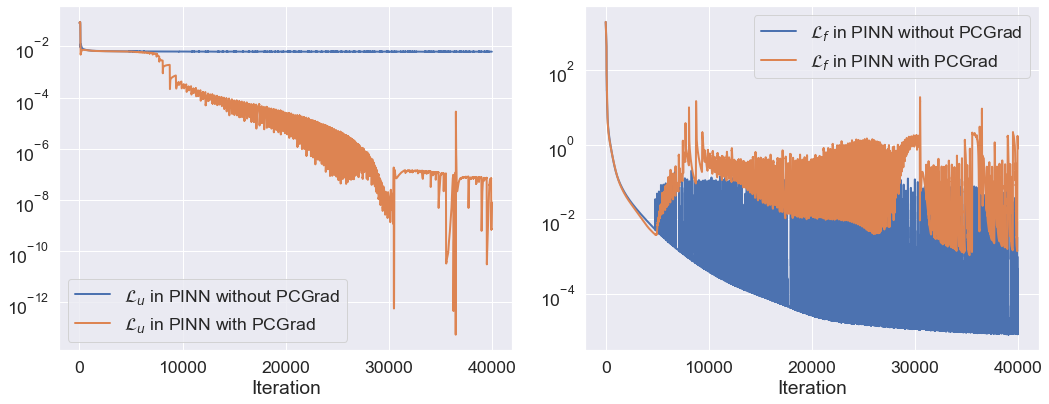

In [21]:
f, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.lineplot(x = range(len(pinn_loss_log[:, 0])), y = pinn_loss_log[:, 0],  linewidth = 2, 
             label = "$\mathcal{L}_u$ in PINN without PCGrad", ax = axes[0])
sns.lineplot(x = range(len(pinn_pcgrad_loss_log[:, 0])), y = pinn_pcgrad_loss_log[:, 0],  linewidth = 2, 
             label = "$\mathcal{L}_u$ in PINN with PCGrad", ax = axes[0])

axes[0].legend()
axes[0].set_yscale("log")
axes[0].set_xlabel("Iteration")

sns.lineplot(x = range(len(pinn_loss_log[:, 1])), y = pinn_loss_log[:, 1],  linewidth = 2, 
             label = "$\mathcal{L}_f$ in PINN without PCGrad", ax = axes[1])

sns.lineplot(x = range(len(pinn_pcgrad_loss_log[:, 1])), y = pinn_pcgrad_loss_log[:, 1],  linewidth = 2, 
             label = "$\mathcal{L}_f$ in PINN with PCGrad", ax = axes[1])

axes[1].legend()
axes[1].set_yscale("log")
axes[1].set_xlabel("Iteration")

plt.tight_layout()
plt.savefig("performance_comparison_medium_homo.pdf")

#### Solution quality comparison

In [22]:
def get_system_performance(df):
    
    df['system_3.5'] = df['state_1']
    df['system_2.0'] = df['state_2']
    df['system_1.8'] = df['state_3'] + df['state_7']
    df['system_1.5'] = df['state_4'] + df['state_6']
    df['system_0'] = df['state_5'] + df['state_8'] + df['state_9'] + df['state_10'] + df['state_11'] + df['state_12']
    
    return df

In [23]:
state_column_names = ['state_1', 'state_2', 'state_3', 'state_4', 'state_5', 'state_6', 'state_7',
                      'state_8', 'state_9', 'state_10', 'state_11', 'state_12']

In [24]:
matlab_solver_solution_df = pd.read_csv('homo_example2.4.csv')
matlab_solver_solution_df.columns = ['time'] + state_column_names

In [25]:
matlab_solver_solution_df = get_system_performance(matlab_solver_solution_df)

In [26]:
matlab_solver_solution_df.drop(labels='time', inplace=True, axis = 1)

In [27]:
matlab_solver_solution_df.head()

,state_1,state_2,state_3,state_4,state_5,state_6,state_7,state_8,state_9,state_10,state_11,state_12,system_3.5,system_2.0,system_1.8,system_1.5,system_0
0,0.98947,0.002718,0.003901,0.003872,0.000011,0.000011,0.000016,0.000005,4.414700e-08,1.555500e-08,2.232800e-08,6.382400e-11,0.98947,0.002718,0.003917,0.003883,0.000016
1,0.97953,0.005252,0.007579,0.007458,0.000045,0.000044,0.000064,0.000023,4.313800e-07,1.523900e-07,2.192600e-07,7.835700e-10,0.97953,0.005252,0.007643,0.007502,0.000068
2,0.96988,0.007703,0.011154,0.010913,0.000089,0.000087,0.000126,0.000045,1.060200e-06,3.744100e-07,5.387400e-07,1.808400e-09,0.96988,0.007703,0.011280,0.011000,0.000136
3,0.96087,0.009961,0.014494,0.014072,0.000154,0.000150,0.000218,0.000078,2.442700e-06,8.729400e-07,1.266300e-06,1.058000e-08,0.96087,0.009961,0.014712,0.014222,0.000237
4,0.95218,0.012125,0.017716,0.017086,0.000229,0.000221,0.000323,0.000117,4.300800e-06,1.551000e-06,2.263800e-06,2.732400e-08,0.95218,0.012125,0.018039,0.017307,0.000354


#### Compare PINN solution with the solution from Matlab solver

In [28]:
mu, sigma = PINN_solver.mu_x, PINN_solver.sigma_x

######################################################################################
# Test data for validating the model predictions
n_star = 500+1
x_star = np.linspace(lb, ub, n_star)[1:] #N_star = x_star.shape[0] 

In [29]:
y_pred = PINN_solver.predict(x_star)
y_pred_pcgrad = PINN_solver_pcgrad.predict(x_star)

In [30]:
y_pred_df = pd.DataFrame(y_pred.numpy(), columns = state_column_names)
y_pred_pcgrad_df = pd.DataFrame(y_pred_pcgrad.numpy(), columns = state_column_names)

In [31]:
y_pred_df = get_system_performance(y_pred_df)
y_pred_pcgrad_df = get_system_performance(y_pred_pcgrad_df)

In [32]:
y_diff = matlab_solver_solution_df - y_pred_df
y_diff_pcgrad = matlab_solver_solution_df - y_pred_pcgrad_df

#### Generate histogram of prediction difference with respect to each state

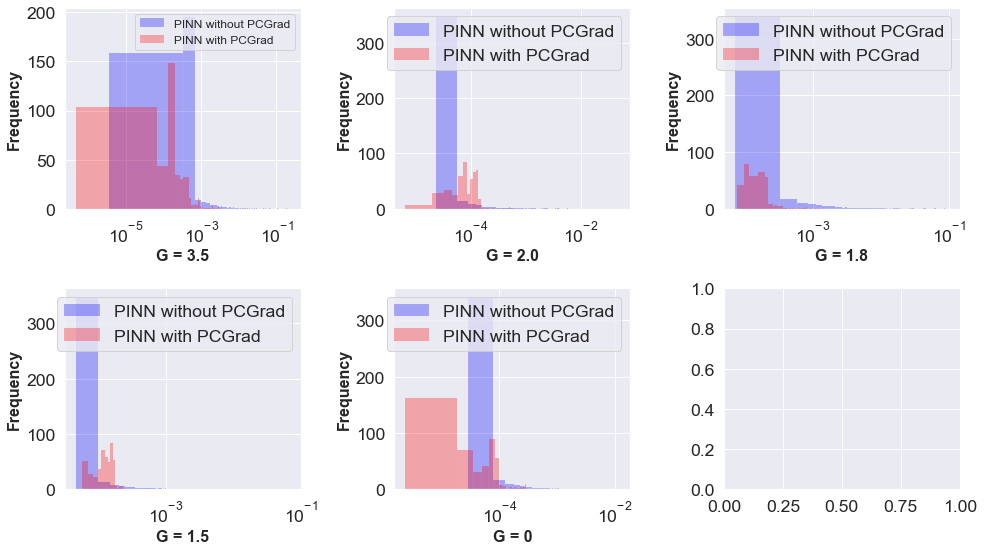

In [33]:
f, axes = plt.subplots(2, 3, figsize=(14, 8))

sns.histplot(np.abs(y_diff['system_3.5']), ax=axes[0][0], alpha =0.3, color='blue', label='PINN without PCGrad')
sns.histplot(np.abs(y_diff_pcgrad['system_3.5']), ax=axes[0][0], alpha =0.3, color='red', label='PINN with PCGrad')

axes[0][0].legend(fontsize=12)
axes[0][0].set_xscale('log')
axes[0][0].set_xlabel('G = 3.5', fontdict=dict(weight='bold'), fontsize=16)
axes[0][0].set_ylabel('Frequency', fontdict=dict(weight='bold'), fontsize=16)


sns.histplot(np.abs(y_diff['system_2.0']), ax=axes[0][1], alpha=0.3, color='blue', label='PINN without PCGrad')
sns.histplot(np.abs(y_diff_pcgrad['system_2.0']), alpha=0.3, ax=axes[0][1], color='red', label='PINN with PCGrad')
axes[0][1].legend()
axes[0][1].set_xscale('log')
axes[0][1].set_xlabel('G = 2.0', fontdict=dict(weight='bold'), fontsize=16)
axes[0][1].set_ylabel('Frequency', fontdict=dict(weight='bold'), fontsize=16)

sns.histplot(np.abs(y_diff['system_1.8']), ax=axes[0][2], alpha=0.3, color='blue', label='PINN without PCGrad')
sns.histplot(np.abs(y_diff_pcgrad['system_1.8']), alpha=0.3, ax=axes[0][2], color='red', label='PINN with PCGrad')
axes[0][2].legend()
axes[0][2].set_xscale('log')
axes[0][2].set_xlabel('G = 1.8', fontdict=dict(weight='bold'), fontsize=16)
axes[0][2].set_ylabel('Frequency', fontdict=dict(weight='bold'), fontsize=16)


sns.histplot(np.abs(y_diff['system_1.5']), ax=axes[1][0], alpha=0.3, color='blue', label='PINN without PCGrad')
sns.histplot(np.abs(y_diff_pcgrad['system_1.5']), alpha=0.3, ax=axes[1][0], color='red', label='PINN with PCGrad')
axes[1][0].legend()
axes[1][0].set_xscale('log')
axes[1][0].set_xlabel('G = 1.5', fontdict=dict(weight='bold'), fontsize=16)
axes[1][0].set_ylabel('Frequency', fontdict=dict(weight='bold'), fontsize=16)


sns.histplot(np.abs(y_diff['system_0']), ax=axes[1][1], alpha=0.3, color='blue', label='PINN without PCGrad')
sns.histplot(np.abs(y_diff_pcgrad['system_0']), alpha=0.3, ax=axes[1][1], color='red', label='PINN with PCGrad')
axes[1][1].legend()
axes[1][1].set_xscale('log')
axes[1][1].set_xlabel('G = 0', fontdict=dict(weight='bold'), fontsize=16)
axes[1][1].set_ylabel('Frequency', fontdict=dict(weight='bold'), fontsize=16)

plt.tight_layout(pad=1)
plt.savefig("histogram_medium_homo.pdf")

#### Compare PINN predictions with Matlab solver

In [34]:
sns.set_style("white")
plt.rcParams['legend.fontsize'] = 12

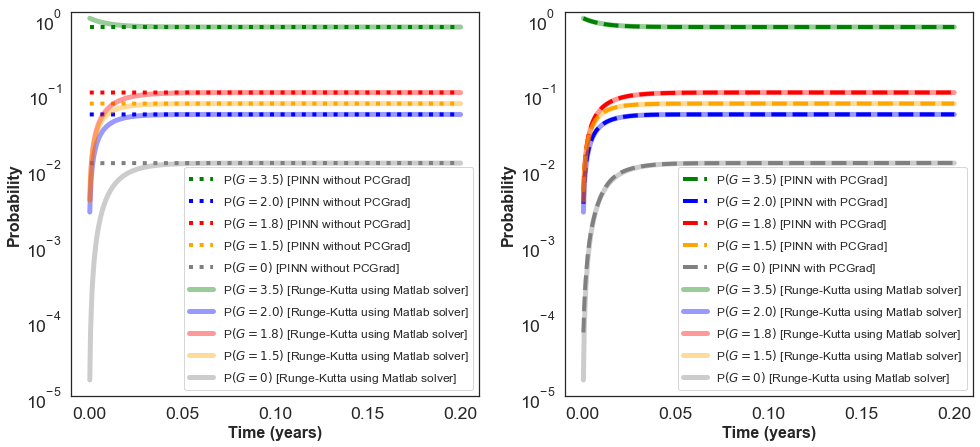

In [35]:
f, ax = plt.subplots(1, 2, figsize=(14, 6.6))


sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_3.5'], label = r'P$\left(G=3.5 \right)$ [PINN without PCGrad]', 
             linewidth = 4, color = 'green', linestyle='dotted', ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_2.0'], label = r'P$\left(G=2.0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'blue', linestyle='dotted', ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.8'], label = r'P$\left(G=1.8 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'red', linestyle='dotted', ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.5'], label = r'P$\left(G=1.5 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'orange', linestyle='dotted', ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_0'], label = r'P$\left(G=0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'gray', linestyle='dotted', ax=ax[0])


sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['system_3.5'], 
             label = r'P$\left(G=3.5 \right)$ [Runge-Kutta using Matlab solver]',
             color = 'green', alpha=0.4, dashes=True, linewidth = 5, ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['system_2.0'], 
             label = r'P$\left(G=2.0 \right)$ [Runge-Kutta using Matlab solver]',
             color = 'blue', alpha=0.4, dashes=True, linewidth = 5, ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['system_1.8'], 
             label = r'P$\left(G=1.8 \right)$ [Runge-Kutta using Matlab solver]',
             color = 'red', alpha=0.4, dashes=True, linewidth = 5, ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['system_1.5'], 
             label = r'P$\left(G=1.5 \right)$ [Runge-Kutta using Matlab solver]',
             color = 'orange', alpha=0.4, dashes=True, linewidth = 5, ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['system_0'], 
             label = r'P$\left(G=0 \right)$ [Runge-Kutta using Matlab solver]',
             color = 'gray', alpha=0.4, dashes=True, linewidth = 5, ax=ax[0])

ax[0].set_yscale("log")
ax[0].set_ylim([1e-5, 1.2])
ax[0].set_xlabel("Time (years)", fontdict=dict(weight='bold'), fontsize=16)
ax[0].set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)



sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad_df['system_3.5'], label = r'P$\left(G=3.5 \right)$ [PINN with PCGrad]',
             color = 'green', linestyle='--', linewidth = 4, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad_df['system_2.0'], label = r'P$\left(G=2.0 \right)$ [PINN with PCGrad]', 
             color = 'blue', linestyle='--', linewidth = 4, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad_df['system_1.8'], label = r'P$\left(G=1.8 \right)$ [PINN with PCGrad]', 
             color = 'red', linestyle='--', linewidth = 4, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad_df['system_1.5'], label = r'P$\left(G=1.5 \right)$ [PINN with PCGrad]',
             color = 'orange', linestyle='--', linewidth = 4, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad_df['system_0'], label = r'P$\left(G=0 \right)$ [PINN with PCGrad]',
             color = 'gray', linestyle='--', linewidth = 4, ax=ax[1])

sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['system_3.5'], 
             label = r'P$\left(G=3.5 \right)$ [Runge-Kutta using Matlab solver]',
             color = 'green', alpha=0.4, dashes=True, linewidth = 5, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['system_2.0'], 
             label = r'P$\left(G=2.0 \right)$ [Runge-Kutta using Matlab solver]',
             color = 'blue', alpha=0.4, dashes=True, linewidth = 5, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['system_1.8'], 
             label = r'P$\left(G=1.8 \right)$ [Runge-Kutta using Matlab solver]',
             color = 'red', alpha=0.4, dashes=True, linewidth = 5, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['system_1.5'], 
             label = r'P$\left(G=1.5 \right)$ [Runge-Kutta using Matlab solver]',
             color = 'orange', alpha=0.4, dashes=True, linewidth = 5, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['system_0'], 
             label = r'P$\left(G=0 \right)$ [Runge-Kutta using Matlab solver]',
             color = 'gray', alpha=0.4, dashes=True, linewidth = 5, ax=ax[1])

ax[1].set_yscale("log")
ax[1].set_ylim([1e-5, 1.2])
ax[1].set_xlabel("Time (years)", fontdict=dict(weight='bold'), fontsize=16)
ax[1].set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)


plt.tight_layout()
plt.savefig("comparison_medium_homo.pdf")

#### Derive RMSE

In [36]:
y_diff['mse'] = y_diff.apply(lambda x: x['system_3.5']**2 + x['system_2.0']**2 + x['system_1.8']**2 + 
                             x['system_1.5']**2 + x['system_0']**2, axis = 1)

y_diff['rmse'] = y_diff['mse'].apply(np.sqrt)

y_diff_pcgrad['mse'] = y_diff_pcgrad.apply(lambda x: x['system_3.5']**2 + x['system_2.0']**2 + x['system_1.8']**2 + 
                             x['system_1.5']**2 + x['system_0']**2, axis = 1)

y_diff_pcgrad['rmse'] = y_diff_pcgrad['mse'].apply(np.sqrt)

In [37]:
print ('RMSE of PINN without PCGrad is', np.mean(y_diff['rmse']))
print ('RMSE of PINN with PCGrad is', np.mean(y_diff_pcgrad['rmse']))

RMSE of PINN without PCGrad is 0.013387323966802
RMSE of PINN with PCGrad is 0.0004544708077466215


In [38]:
(np.mean(y_diff['rmse']) - np.mean(y_diff_pcgrad['rmse']))/np.mean(y_diff['rmse'])

0.9660521543458855